# Ensemble (CNN+Random Forest/SVM)



> Dataset: [Chest Xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

## Imputs

In [ ]:
from google.colab import drive

import os
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted at /content/drive")

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.mount('/content')

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded -O chest_xray.zip
!unzip chest_xray.zip

In [ ]:
!pip install tensorflow scikit-posthocs joblib -qqq

In [ ]:
import os
import gc
import pandas as pd
from scipy import stats
import numpy as np
import tensorflow as tf
import json
import pickle
import joblib
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance


import time
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
# RESULTS_DIR = "/content/drive/MyDrive/UEMA/DEEP LEARNING/Atividade IV/saved_results_04_05"
RESULTS_DIR = "/content/drive/MyDrive/UEMA/DEEP LEARNING/Atividade IV/saved_results_15_05"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Configuration

In [ ]:
class ChestXRayClassifier:
   def __init__(self, img_size=(224, 224), k_folds=5):
       self.img_size = img_size
       self.k_folds = k_folds
       self.histories = {}
       self.models = {
           "MobileNetV2": self.create_mobilenet(),
           "VGG16": self.create_vgg16(),
           "EfficientNetB0": self.create_efficientnet(),
           #  "ResNet50": self.create_resnet(),
           #  "DenseNet121": self.create_densenet()
       }
       self.rf_model = None

   def initialize_models(self):
       self.models = {
           "MobileNetV2": self.create_mobilenet(),
           "VGG16": self.create_vgg16(),
           "EfficientNetB0": self.create_efficientnet(),
       }
       self.rf_model = None


   def create_mobilenet(self):
       return self.build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(*self.img_size, 3)))

   def create_vgg16(self):
       return self.build_model(VGG16(weights='imagenet', include_top=False, input_shape=(*self.img_size, 3)))


   def create_efficientnet(self):
        """Cria modelo EfficientNetB0 com camadas customizadas"""
        base_model = EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(*self.img_size, 3)
        )
        return self.build_model(base_model)

   def freeze_layers(self, base_model):
      # Congela as camadas exceto as últimas 20
      for layer in base_model.layers[:-20]:
          layer.trainable = False
      return base_model

   def build_model(self, base_model):

      base_model = self.freeze_layers(base_model)
      inputs = tf.keras.Input(shape=(*self.img_size, 3))
      x = base_model(inputs, training=False)
      x = tf.keras.layers.GlobalAveragePooling2D()(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dense(128, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.5)(x)
      x = tf.keras.layers.Dense(64, activation='relu')(x)
      x = tf.keras.layers.Dropout(0.5)(x)
      outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      model = tf.keras.Model(inputs, outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # low learning rate - EfficientNetB0 (based in El Asnaoui et al.)
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
      return model

   def load_data(self, data_dir):

       y_train = np.array([])
       for root, dirs, files in os.walk(os.path.join(data_dir, 'train', 'NORMAL')):
           y_train = np.append(y_train, np.zeros(len(files)))
       for root, dirs, files in os.walk(os.path.join(data_dir, 'train', 'PNEUMONIA')):
           y_train = np.append(y_train, np.ones(len(files)))

       neg, pos = np.bincount(y_train.astype(int))
       total = neg + pos
       weight_for_0 = (1 / neg) * (total / 2.0)
       weight_for_1 = (1 / pos) * (total / 2.0)
       self.class_weights = {0: weight_for_0, 1: weight_for_1}
       print(f"Class weights calculados: {self.class_weights}")

       # data augmentation
       # EfficientNetB0
       efficientnet_datagen = ImageDataGenerator(
           preprocessing_function=preprocess_input,
           rotation_range=20,
           brightness_range=[0.6, 1.3],
           shear_range=0.3,
           zoom_range=[0.8, 1.0],
           fill_mode='constant',
           validation_split=0.2
       )

       efficientnet_test_datagen = ImageDataGenerator(
           preprocessing_function=preprocess_input
       )

       standard_datagen = ImageDataGenerator(
           rescale=1./255,
           validation_split=0.2,
           rotation_range=30,
           width_shift_range=0.3,
           height_shift_range=0.3,
           horizontal_flip=True,
           zoom_range=0.2,
           shear_range=0.2,
           brightness_range=[0.8,1.2]
       )

       standard_test_datagen = ImageDataGenerator(rescale=1./255)

       self.datagens = {
           "EfficientNetB0": {
               "train": efficientnet_datagen.flow_from_directory(
                   os.path.join(data_dir, 'train'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   subset='training'
               ),
               "val": efficientnet_datagen.flow_from_directory(
                   os.path.join(data_dir, 'train'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   subset='validation'
               ),
               "test": efficientnet_test_datagen.flow_from_directory(
                   os.path.join(data_dir, 'test'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   shuffle=False
               )
           },
           "standard": {
               "train": standard_datagen.flow_from_directory(
                   os.path.join(data_dir, 'train'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   subset='training'
               ),
               "val": standard_datagen.flow_from_directory(
                   os.path.join(data_dir, 'train'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   subset='validation'
               ),
               "test": standard_test_datagen.flow_from_directory(
                   os.path.join(data_dir, 'test'),
                   target_size=self.img_size,
                   batch_size=16,
                   class_mode='binary',
                   shuffle=False
               )
           }
       }


       self.initialize_models()


       return (self.datagens["standard"]["train"],
               self.datagens["standard"]["val"],
               self.datagens["standard"]["test"])

   def extract_features(self, model, generator):

        if isinstance(model, tf.keras.Sequential):

            features_layer_index = -2
            feature_extractor = tf.keras.Model(
                inputs=model.inputs,
                outputs=model.layers[features_layer_index].output
            )
        else:

            feature_extractor = tf.keras.Model(
                inputs=model.input,
                outputs=model.layers[-3].output
            )

        features, labels = [], []
        generator.reset()  # resetar o gerador
        for _ in range(len(generator)):
            batch_x, batch_y = next(generator)
            batch_features = feature_extractor.predict(batch_x, verbose=0)
            features.append(batch_features)
            labels.append(batch_y)
        return np.concatenate(features), np.concatenate(labels)

   def train_random_forest(self, train_generator):
       features = []
       labels = []

       for model_name, model in self.models.items():
           print(f"Extracting features from the {model_name}")
           model_features, batch_labels = self.extract_features(model, train_generator)
           features.append(model_features)
           if len(labels) == 0:
               labels = batch_labels

       combined_features = np.concatenate(features, axis=1)
       self.rf_model = RandomForestClassifier(n_estimators=100,
            max_depth=15,
            # min_samples_split=5,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1)
       self.rf_model.fit(combined_features, labels)

   def train_models(self, train_generator, val_generator, test_generator):
      results = {model: [] for model in self.models.keys()}
      results["Random Forest"] = []
      results["Ensemble (All)"] = []  # Ensemble all models
      results["Ensemble (No EfficientNet)"] = []  # Ensemble without EfficientNetB0

      kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)
      for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_generator)))):
          print(f"\nFold {fold + 1}/{self.k_folds}")

          callbacks = {
              "standard": [
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
                  )
              ],
              "efficientnet": [
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
                  ),
                  tf.keras.callbacks.ReduceLROnPlateau(
                      monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
                  )
              ]
          }

          # CNNs
          for model_name, model in self.models.items():
              print(f"Treinando {model_name}")


              if model_name == "EfficientNetB0":
                  model_train_gen = self.datagens["EfficientNetB0"]["train"]
                  model_val_gen = self.datagens["EfficientNetB0"]["val"]
                  model_callbacks = callbacks["efficientnet"]
                  model_class_weights = self.class_weights
              else:
                  model_train_gen = train_generator
                  model_val_gen = val_generator
                  model_callbacks = callbacks["standard"]
                  model_class_weights = None


              history = model.fit(
                  model_train_gen,
                  validation_data=model_val_gen,
                  epochs=15 if model_name == "EfficientNetB0" else 10,
                  steps_per_epoch=len(model_train_gen),
                  validation_steps=len(model_val_gen),
                  callbacks=model_callbacks,
                  class_weight=model_class_weights,
                  verbose=1
              )

              # pro EfficientNetB0, fazer fine-tuning
              # if model_name == "EfficientNetB0":
              #     print(f"Fine-tuning {model_name}")

              #     # Descongelar as camadas do modelo base
              #     base_model = model.layers[0]
              #     base_model.trainable = True

              #     # Recompilar com learning rate mais baixo
              #     model.compile(
              #         optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              #         loss='binary_crossentropy',
              #         metrics=['accuracy', tf.keras.metrics.AUC()]
              #     )

              #     # Treinar novamente com fine-tuning
              #     history_ft = model.fit(
              #         model_train_gen,
              #         validation_data=model_val_gen,
              #         epochs=10,
              #         steps_per_epoch=len(model_train_gen),
              #         validation_steps=len(model_val_gen),
              #         callbacks=model_callbacks,
              #         class_weight=model_class_weights,
              #         verbose=1
              #     )

              #     # Combinar os históricos
              #     combined_history = {}
              #     for key in history.history:
              #         combined_history[key] = history.history[key] + history_ft.history[key]

              #     self.histories[model_name] = combined_history

              self.histories[model_name] = history.history

          self.train_random_forest(train_generator)

          y_preds = {}
          for model_name, model in self.models.items():
              test_gen = self.datagens["EfficientNetB0"]["test"] if model_name == "EfficientNetB0" else test_generator
              y_preds[model_name] = model.predict(test_gen, steps=len(test_gen))

          rf_features = []
          for model_name, model in self.models.items():
              rf_feat, _ = self.extract_features(model, test_generator)
              rf_features.append(rf_feat)
          rf_combined = np.concatenate(rf_features, axis=1)
          y_preds["Random Forest"] = self.rf_model.predict_proba(rf_combined)[:, 1]

          ensemble_all_preds = np.zeros(y_preds[list(y_preds.keys())[0]].shape[0])
          for model_name, preds in y_preds.items():
              preds = np.ravel(preds)
              ensemble_all_preds += preds
          ensemble_all_preds /= len(y_preds)
          y_preds["Ensemble (All)"] = ensemble_all_preds

          ensemble_without_effnet_preds = np.zeros(y_preds[list(y_preds.keys())[0]].shape[0])
          count = 0
          for model_name, preds in y_preds.items():
              if model_name != "EfficientNetB0":
                  preds = np.ravel(preds)
                  ensemble_without_effnet_preds += preds
                  count += 1
          ensemble_without_effnet_preds /= count
          y_preds["Ensemble (No EfficientNet)"] = ensemble_without_effnet_preds


          for model_name, preds in y_preds.items():
              self.plot_confusion_matrix(test_generator.classes, preds, f"{model_name}_fold{fold}")
              metrics = self.save_metrics(test_generator.classes, preds, f"{model_name}_fold{fold}")
              results[model_name].append(metrics)

          self.plot_roc_curves(test_generator.classes, y_preds, fold)

      return results, y_preds, self.histories

   def plot_training_history(self):

        plt.style.use("ggplot")

        for model_name, history in self.histories.items():
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Accuracy
            axes[0].plot(history['accuracy'], label='Train', linewidth=2)
            axes[0].plot(history['val_accuracy'], label='Validation', linewidth=2, linestyle='dashed')
            axes[0].set_xlabel('Epoch', fontsize=14)
            axes[0].set_ylabel('Accuracy', fontsize=14)
            axes[0].set_title(f'Accuracy - {model_name}', fontsize=16)
            axes[0].legend(fontsize=12)
            axes[0].grid(True)

            # Loss
            axes[1].plot(history['loss'], label='Train', linewidth=2)
            axes[1].plot(history['val_loss'], label='Validation', linewidth=2, linestyle='dashed')
            axes[1].set_xlabel('Epoch', fontsize=14)
            axes[1].set_ylabel('Loss', fontsize=14)
            axes[1].set_title(f'Loss - {model_name}', fontsize=16)
            axes[1].legend(fontsize=12)
            axes[1].grid(True)

            plt.tight_layout()
            plt.savefig(f"{RESULTS_DIR}/{model_name}_training_history.png", dpi=300, bbox_inches='tight')
            plt.show()

   def plot_confusion_matrix(self, y_true, y_pred, model_name):

        y_pred_classes = (y_pred > 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred_classes)

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14},
                    xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label', fontsize=14)
        plt.title(f'{model_name}', fontsize=16)

        plt.savefig(f"{RESULTS_DIR}/{model_name}_confusion_matrix.png", dpi=300, bbox_inches='tight')
        plt.show()

   def plot_roc_curves(self, y_true, y_preds, fold):
        plt.figure(figsize=(8, 6))

        for model_name, y_pred in y_preds.items():
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            auc = roc_auc_score(y_true, y_pred)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Reference line
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(f'ROC Curve - Fold {fold}', fontsize=16)
        plt.legend(fontsize=12)

        plt.savefig(f"{RESULTS_DIR}/roc_curves_fold{fold}.png", dpi=300, bbox_inches='tight')
        plt.show()


   def save_metrics(self, y_true, y_pred, model_name):
       y_pred_classes = (y_pred > 0.5).astype(int)


       metrics = {
           "accuracy": accuracy_score(y_true, y_pred_classes),
           "balanced_accuracy": balanced_accuracy_score(y_true, y_pred_classes),
           "precision": precision_score(y_true, y_pred_classes, average='weighted'),
           "recall": recall_score(y_true, y_pred_classes, average='weighted'),
           "f1-score": f1_score(y_true, y_pred_classes, average='weighted'),
           "f1-macro": f1_score(y_true, y_pred_classes, average='macro'),
       }

       try:
           metrics["auc"] = roc_auc_score(y_true, y_pred)
       except:
           metrics["auc"] = None


       with open(os.path.join(RESULTS_DIR, f"{model_name}_metrics.json"), "w") as f:
           json.dump(metrics, f, indent=4)

       cm = confusion_matrix(y_true, y_pred_classes)
       np.save(os.path.join(RESULTS_DIR, f"{model_name}_confusion_matrix.npy"), cm)

       return metrics

   def analyze_rf_feature_importance(self, feature_extractor_layers=None):

       if self.rf_model is None:
           print("Error")
           return None


       test_generator = self.datagens["standard"]["test"]


       features = []
       for model_name, model in self.models.items():
           model_features, _ = self.extract_features(model, test_generator)
           features.append(model_features)

       combined_features = np.concatenate(features, axis=1)
       y_true = test_generator.classes


       result = permutation_importance(
           self.rf_model, combined_features, y_true,
           n_repeats=10, random_state=42, n_jobs=-1
       )

       feature_names = []
       for model_name in self.models.keys():

           feature_count = features[0].shape[1]
           for i in range(feature_count):
               feature_names.append(f"{model_name}_{i}")


       indices = np.argsort(result.importances_mean)[::-1]

       plt.figure(figsize=(12, 8))
       plt.title("Importance of Features - Random Forest", fontsize=16)
       plt.bar(range(30), result.importances_mean[indices[:30]])
       plt.xticks(range(30), [feature_names[idx] for idx in indices[:30]], rotation=90, fontsize=10)
       plt.ylabel("Importância", fontsize=14)
       plt.tight_layout()
       plt.savefig(os.path.join(RESULTS_DIR, "rf_feature_importance.png"), dpi=300)
       plt.show()

       importance_df = pd.DataFrame({
           'Feature': feature_names,
           'Importance': result.importances_mean,
           'StdDev': result.importances_std
       })
       importance_df = importance_df.sort_values('Importance', ascending=False)
       importance_df.to_csv(os.path.join(RESULTS_DIR, "rf_feature_importance.csv"), index=False)


       if feature_extractor_layers:
           layer_results = {}

           for model_name, layers in feature_extractor_layers.items():
               model = self.models[model_name]
               for layer_idx in layers:
                   layer_name = model.layers[layer_idx].name


                   layer_extractor = tf.keras.Model(
                       inputs=model.input,
                       outputs=model.layers[layer_idx].output
                   )


                   features = []
                   test_generator.reset()
                   for _ in range(len(test_generator)):
                       batch_x, batch_y = next(test_generator)
                       batch_features = layer_extractor.predict(batch_x, verbose=0)

                       batch_features = np.reshape(batch_features, (batch_features.shape[0], -1))
                       features.append(batch_features)

                   layer_features = np.concatenate(features)

                   layer_rf = RandomForestClassifier(n_estimators=100, random_state=42)
                   layer_rf.fit(layer_features, test_generator.classes)

                   y_pred = layer_rf.predict(layer_features)
                   y_pred_proba = layer_rf.predict_proba(layer_features)[:, 1]

                   layer_results[f"{model_name}_{layer_name}"] = {
                       'accuracy': accuracy_score(test_generator.classes, y_pred),
                       'auc': roc_auc_score(test_generator.classes, y_pred_proba)
                   }

                   print(f"Layer {model_name}_{layer_name}: Acurácia={layer_results[f'{model_name}_{layer_name}']['accuracy']:.4f}, AUC={layer_results[f'{model_name}_{layer_name}']['auc']:.4f}")

           with open(os.path.join(RESULTS_DIR, "layer_performance.json"), "w") as f:
               json.dump(layer_results, f, indent=4)

       return importance_df

In [ ]:
class SVMKFoldEvaluator:
    def __init__(self, models, results_dir, img_size=(224, 224), k_folds=5):
        self.models = models
        self.results_dir = results_dir
        self.img_size = img_size
        self.k_folds = k_folds
        self.best_params = None

    def extract_features(self, generator):
        combined_features = []
        labels = None

        for model_name, model in self.models.items():
            print(f"Extracting features from the {model_name}")
            if model_name == "EfficientNetB0":
                feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[3].output)
            else:
                feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)

            features = []
            all_labels = []
            generator.reset()

            for _ in range(len(generator)):
                batch_x, batch_y = next(generator)
                batch_features = feature_extractor.predict(batch_x, verbose=0)
                features.append(batch_features)
                all_labels.append(batch_y)

            model_features = np.concatenate(features)
            combined_features.append(model_features)

            if labels is None:
                labels = np.concatenate(all_labels)

        return np.concatenate(combined_features, axis=1), labels

    def run_grid_search(self, X_train, y_train):
        print("GridSearchCV for SVM...")
        param_grid = {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.1]
        }

        grid_search = GridSearchCV(
            SVC(probability=True, class_weight='balanced'),
            param_grid,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        self.best_params = grid_search.best_params_
        joblib.dump(grid_search.best_estimator_, os.path.join(self.results_dir, 'best_svm_model.joblib'))

        with open(os.path.join(self.results_dir, 'svm_best_params.json'), 'w') as f:
            json.dump(self.best_params, f, indent=4)

        print(f"Best hyperparameters:{self.best_params}")

    def evaluate(self, generator):
        print("Evaluating SVM with best fixed hyperparameters in K-Fold...")

        X, y = self.extract_features(generator)
        kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        all_preds = []
        all_probs = []
        all_y = []

        fold_metrics = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            print(f"\nFold {fold+1}/{self.k_folds}")

            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            clf = SVC(**self.best_params, probability=True, class_weight='balanced')
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            y_proba = clf.predict_proba(X_test)[:, 1]

            all_preds.extend(y_pred)
            all_probs.extend(y_proba)
            all_y.extend(y_test)

            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                'f1_macro': f1_score(y_test, y_pred, average='macro'),
                'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
                'auc': roc_auc_score(y_test, y_proba)
            }
            fold_metrics.append(metrics)

            cm = confusion_matrix(y_test, y_pred)
            np.save(os.path.join(self.results_dir, f"svm_confusion_matrix_fold{fold}.npy"), cm)
            self.plot_confusion_matrix(cm, fold)
            self.plot_roc_curve(y_test, y_proba, fold)

        with open(os.path.join(self.results_dir, "svm_kfold_metrics.json"), "w") as f:
            json.dump(fold_metrics, f, indent=4)

        return fold_metrics, all_probs, all_y

    def plot_confusion_matrix(self, cm, fold):
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'SVM Confusion Matrix - Fold {fold}')
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, f"svm_confusion_matrix_fold{fold}.png"), dpi=300)
        plt.close()

    def plot_roc_curve(self, y_true, y_prob, fold):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = roc_auc_score(y_true, y_prob)
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', linewidth=2)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(f'SVM ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, f"svm_roc_curve_fold{fold}.png"), dpi=300)
        plt.close()

In [ ]:
def check_dataset_distribution(data_dir):
    for subset in ['train', 'test']:
        subset_dir = os.path.join(data_dir, subset)
        print(f"\nDistribution in the set{subset}:")

        for class_name in os.listdir(subset_dir):
            class_path = os.path.join(subset_dir, class_name)
            if os.path.isdir(class_path):
                num_samples = len(os.listdir(class_path))
                print(f"  Class {class_name}: {num_samples} sample")

In [ ]:
def compare_models_kruskal(results):

    metrics_to_test = ["accuracy", "balanced_accuracy", "f1-score", "f1-macro", "auc"]
    for metric in metrics_to_test:
        model_metrics = {model: [] for model in results.keys()}

        for model_name, fold_results in results.items():
            for fold in fold_results:
                if metric in fold:
                    model_metrics[model_name].append(fold[metric])

        if any(len(values) == 0 for values in model_metrics.values()):
            print(f"\nskip {metric} .")
            continue

        min_len = min(len(m) for m in model_metrics.values())
        model_metrics = {k: v[:min_len] for k, v in model_metrics.items()}

        model_data = list(model_metrics.values())

        if len(model_data) < 2 or any(len(x) < 2 for x in model_data):
            print(f"\nInsufficient data to test {metric}, skipping")
            continue

        h_statistic, p_value = stats.kruskal(*model_data)

        print(f"\nKruskal-Wallis para {metric}:")
        print(f"   H-statistic: {h_statistic:.4f}")
        print(f"   p-value: {p_value:.4f}")

        if p_value < 0.05:
            print("There is a statistically significant difference between the models (p < 0.05)")

            df = pd.DataFrame()
            for model_name, values in model_metrics.items():
                model_df = pd.DataFrame({
                    'value': values,
                    'model': model_name
                })
                df = pd.concat([df, model_df])

            dunn_results = sp.posthoc_dunn(df, val_col='value', group_col='model', p_adjust='bonferroni')
            print("\nDunn's test results (p-values adjusted by Bonferroni):")
            print(dunn_results)

            dunn_results.to_csv(os.path.join(RESULTS_DIR, f"dunn_test_{metric}.csv"))

            plt.figure(figsize=(10, 8))
            ax = sns.heatmap(dunn_results, annot=True, fmt=".4f", cmap="coolwarm")
            plt.title(f"Teste de Dunn - {metric}", fontsize=16)
            plt.tight_layout()
            plt.savefig(os.path.join(RESULTS_DIR, f"dunn_heatmap_{metric}.png"), dpi=300)
            plt.show()
        else:
            print("There is no statistically significant difference between the models (p >= 0.05)")

In [ ]:
def plot_roc_curves_all_folds(y_true_folds, y_preds_folds, results_dir):
    plt.figure(figsize=(10, 8))

    mean_fpr = np.linspace(0, 1, 100)
    tpr_values = {model: [] for model in y_preds_folds[0].keys()}
    auc_values = {model: [] for model in y_preds_folds[0].keys()}

    for fold_idx in range(len(y_true_folds)):
        y_true = y_true_folds[fold_idx]
        for model_name, y_pred in y_preds_folds[fold_idx].items():
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            auc = roc_auc_score(y_true, y_pred)
            auc_values[model_name].append(auc)
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_values[model_name].append(tpr_interp)


            plt.plot(fpr, tpr, alpha=0.3, linestyle='dashed')


    for model_name in tpr_values.keys():
        mean_tpr = np.mean(tpr_values[model_name], axis=0)
        mean_auc = np.mean(auc_values[model_name])
        std_auc = np.std(auc_values[model_name])

        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})', linewidth=2)


    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)


    plt.xlabel('False Positive Rate (FPR)', fontsize=14)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14)
    plt.title('ROC Curves - Average and Folds', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.savefig(f"{results_dir}/roc_curves_all_folds.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_dunn_matrix(accuracy_matrix, model_names, results_dir):

    folds = np.repeat(range(accuracy_matrix.shape[0]), accuracy_matrix.shape[1])
    models = np.tile(model_names, accuracy_matrix.shape[0])
    scores = accuracy_matrix.flatten()

    df = pd.DataFrame({'Fold': folds, 'Model': models, 'Accuracy': scores})

    dunn_results = sp.posthoc_dunn(df, val_col='Accuracy', group_col='Model', p_adjust='bonferroni')
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        dunn_results,
        annot=True,
        fmt=".4f",
        cmap="coolwarm",
        linewidths=1,
        linecolor="black",
        cbar=True,
        square=True
    )

    plt.title("Dunn's Test p-value matrix (adjusted)", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=12, rotation=45, ha="right")
    plt.yticks(fontsize=12, rotation=0)

    for i in range(len(model_names)):
        for j in range(len(model_names)):
            value = dunn_results.iloc[i, j]
            if value < 0.05:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=2))

    plt.tight_layout()
    plt.savefig(f"{results_dir}/dunn_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

    return dunn_results

## Training and show

In [ ]:
DATA_DIR = '/content/chest_xray'
check_dataset_distribution(DATA_DIR)


Distribuição no conjunto train:
  Classe NORMAL: 1349 amostras
  Classe PNEUMONIA: 3884 amostras

Distribuição no conjunto test:
  Classe NORMAL: 234 amostras
  Classe PNEUMONIA: 390 amostras


In [ ]:
gc.collect()

0

In [ ]:
classifier = ChestXRayClassifier()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
gc.collect()

0

In [ ]:
train_generator, val_generator, test_generator = classifier.load_data(DATA_DIR)

Class weights calculados: {0: np.float64(1.9395848776871756), 1: np.float64(0.6736611740473738)}
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
gc.collect()

42584


Fold 1/5
Treinando MobileNetV2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 144s 471ms/step - accuracy: 0.4242 - auc_3: 0.5600 - loss: 1.3103 - val_accuracy: 0.8000 - val_auc_3: 0.8780 - val_loss: 0.4626
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.5677 - auc_3: 0.7075 - loss: 0.9304 - val_accuracy: 0.8651 - val_auc_3: 0.9247 - val_loss: 0.3120
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 392ms/step - accuracy: 0.6918 - auc_3: 0.8216 - loss: 0.6459 - val_accuracy: 0.8727 - val_auc_3: 0.9467 - val_loss: 0.2651
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 392ms/step - accuracy: 0.7421 - auc_3: 0.8475 - loss: 0.5492 - val_accuracy: 0.8861 - val_auc_3: 0.9578 - val_loss: 0.2373
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.7964 - auc_3: 0.8780 - loss: 0.4682 - val_accuracy: 0.9091 - val_auc_3: 0.9735 - val_loss: 0.2027
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 391ms/step - accuracy: 0.8201 - auc_3: 0.8919 - loss: 0.4212 - val_accuracy: 0.9072 - val_auc_3: 0.9699 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


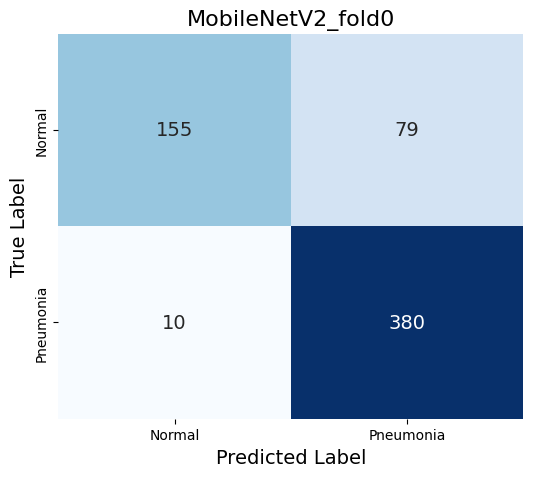

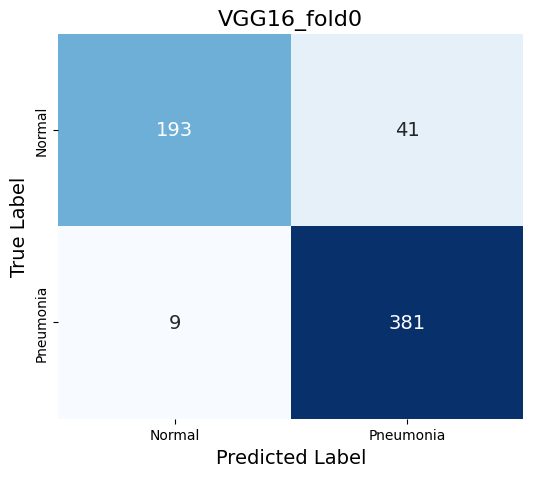

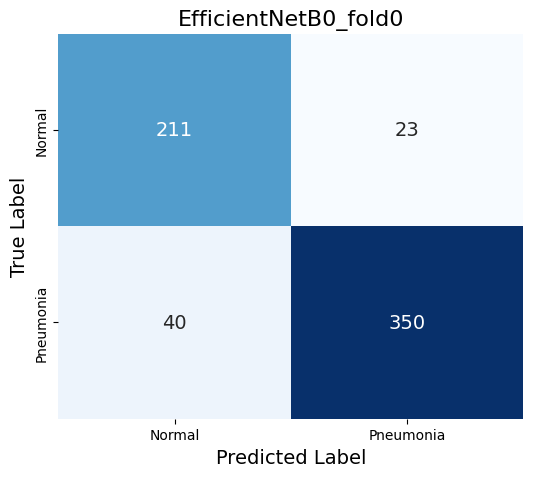

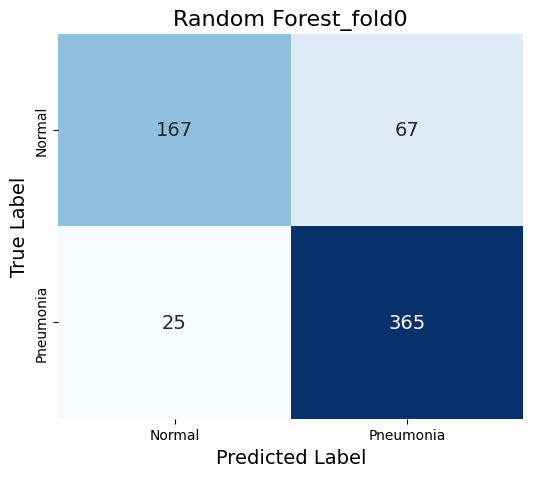

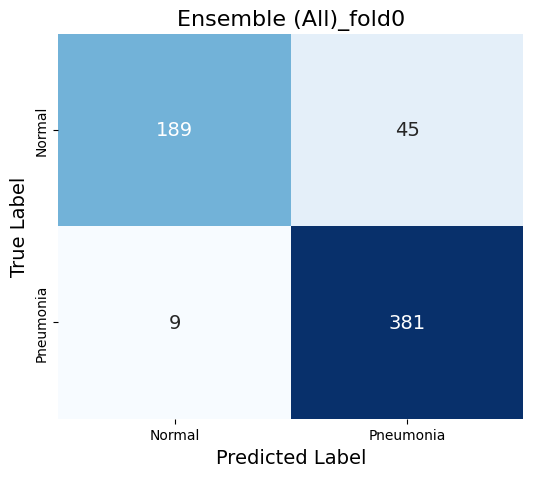

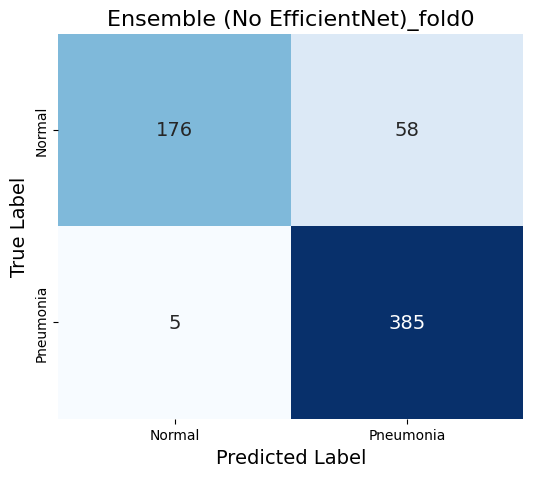

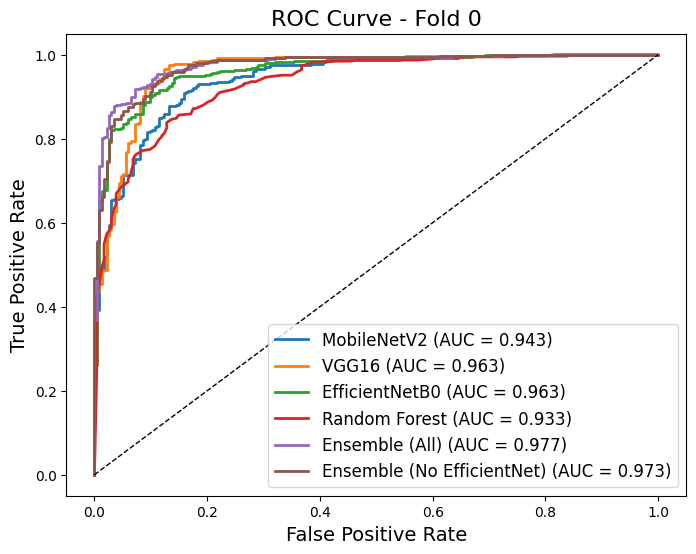


Fold 2/5
Treinando MobileNetV2
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 104s 397ms/step - accuracy: 0.8810 - auc_3: 0.9412 - loss: 0.2844 - val_accuracy: 0.9311 - val_auc_3: 0.9796 - val_loss: 0.1621
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 394ms/step - accuracy: 0.8919 - auc_3: 0.9499 - loss: 0.2641 - val_accuracy: 0.9435 - val_auc_3: 0.9857 - val_loss: 0.1392
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 104s 396ms/step - accuracy: 0.8917 - auc_3: 0.9538 - loss: 0.2460 - val_accuracy: 0.9340 - val_auc_3: 0.9783 - val_loss: 0.1625
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.8960 - auc_3: 0.9543 - loss: 0.2399 - val_accuracy: 0.9330 - val_auc_3: 0.9829 - val_loss: 0.1501
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 391ms/step - accuracy: 0.8843 - auc_3: 0.9454 - loss: 0.2713 - val_accuracy: 0.9435 - val_auc_3: 0.9852 - val_loss: 0.1386
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.8966 - auc_3: 0.9526 - loss: 0.2545 - val_accuracy: 0.9416

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


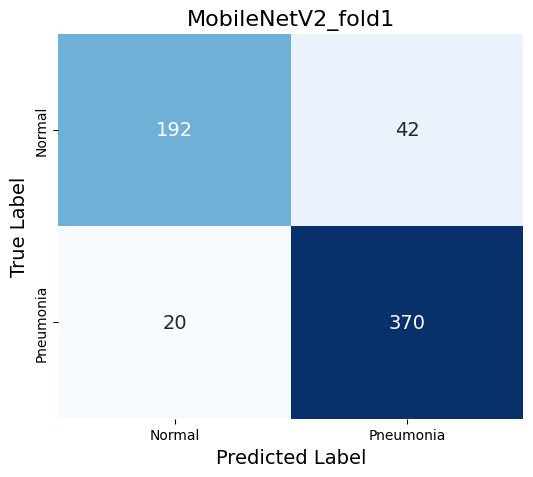

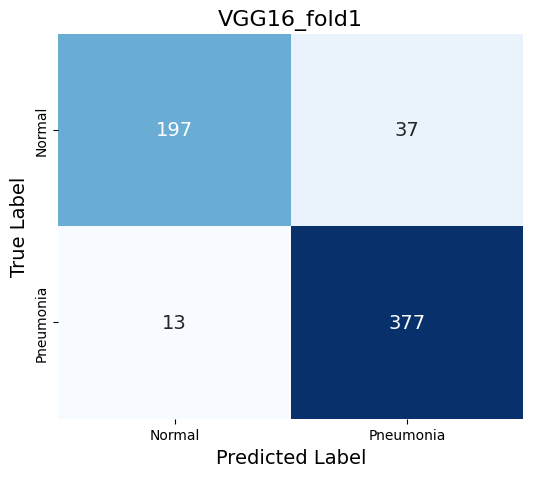

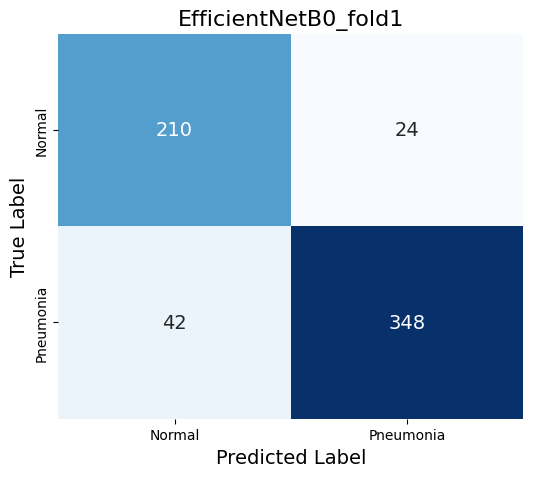

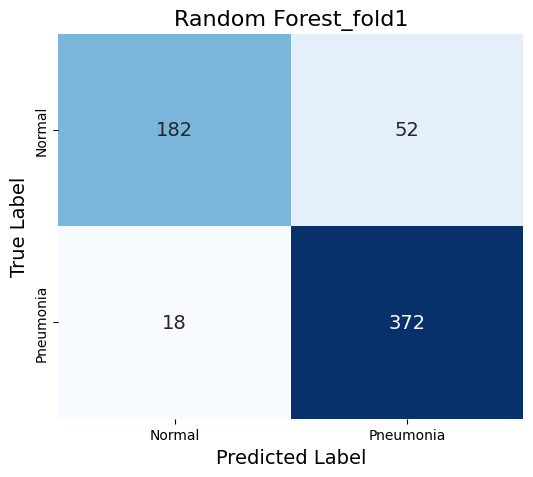

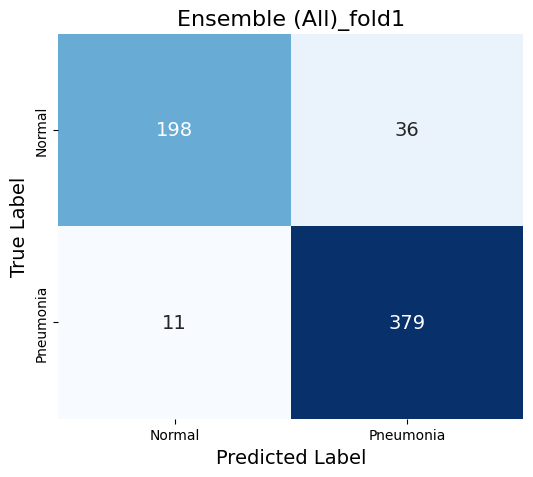

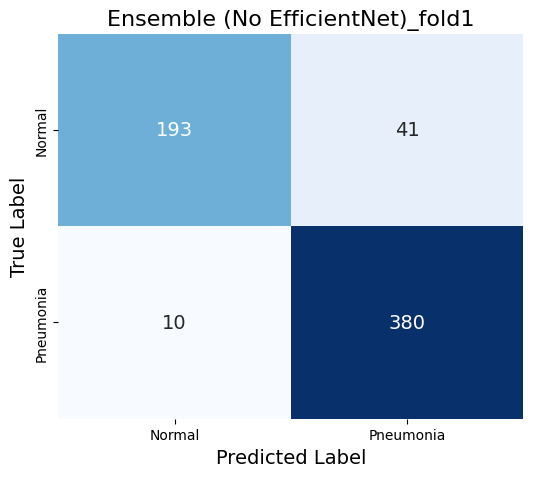

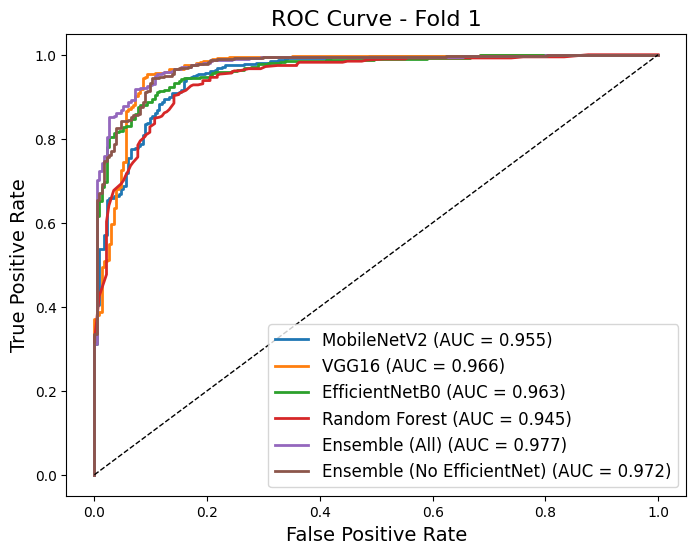


Fold 3/5
Treinando MobileNetV2
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 393ms/step - accuracy: 0.9188 - auc_3: 0.9638 - loss: 0.2119 - val_accuracy: 0.9311 - val_auc_3: 0.9829 - val_loss: 0.1550
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 101s 387ms/step - accuracy: 0.9104 - auc_3: 0.9637 - loss: 0.2106 - val_accuracy: 0.9550 - val_auc_3: 0.9908 - val_loss: 0.1168
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.9170 - auc_3: 0.9671 - loss: 0.2082 - val_accuracy: 0.9502 - val_auc_3: 0.9891 - val_loss: 0.1264
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 101s 386ms/step - accuracy: 0.9195 - auc_3: 0.9697 - loss: 0.1973 - val_accuracy: 0.9464 - val_auc_3: 0.9863 - val_loss: 0.1344
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 388ms/step - accuracy: 0.9241 - auc_3: 0.9677 - loss: 0.2068 - val_accuracy: 0.9483 - val_auc_3: 0.9910 - val_loss: 0.1203
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 392ms/step - accuracy: 0.9116 - auc_3: 0.9623 - loss: 0.2242 - val_accuracy: 0.9455

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


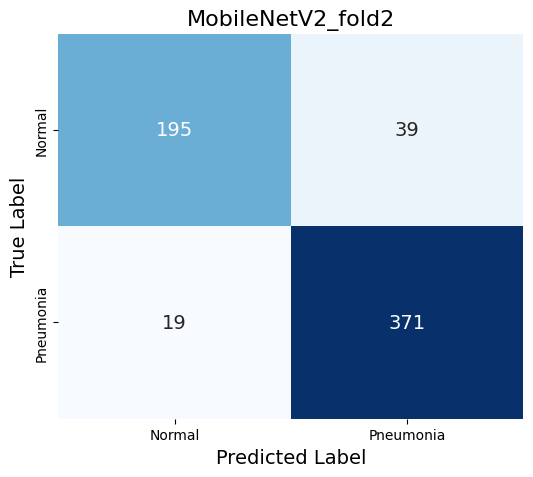

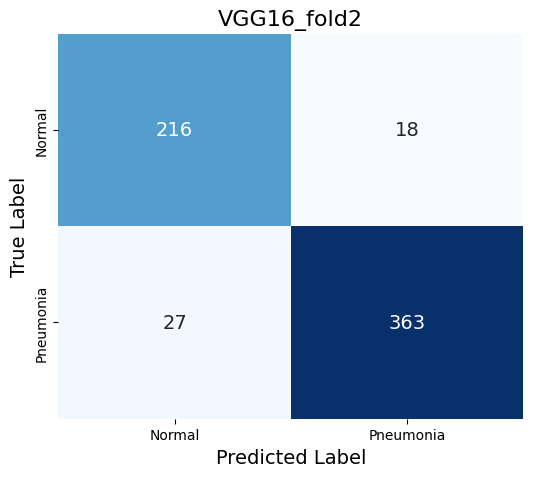

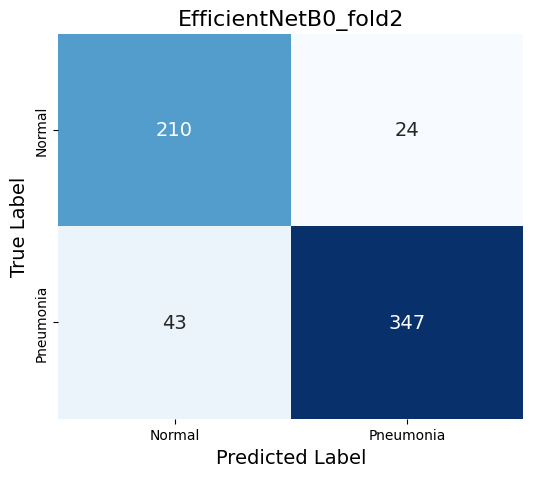

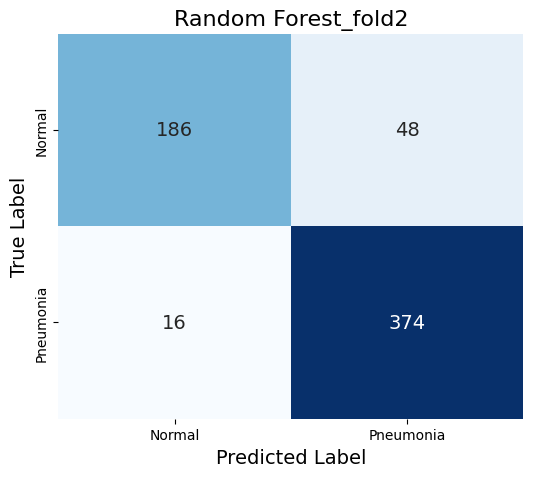

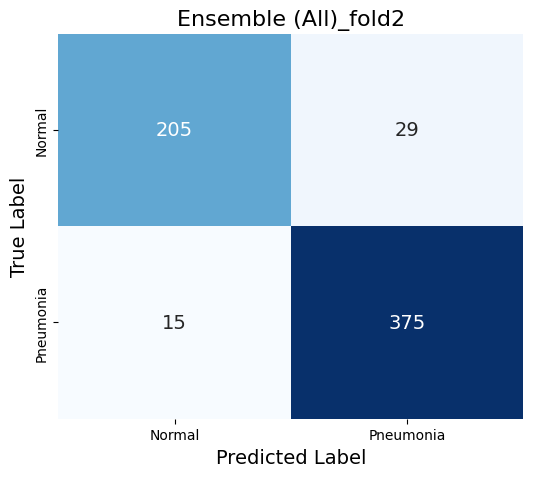

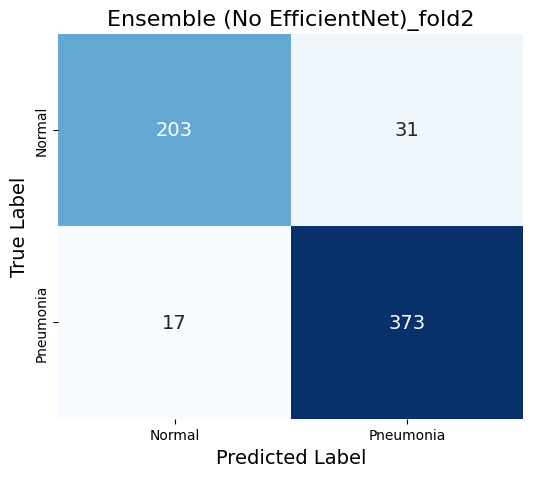

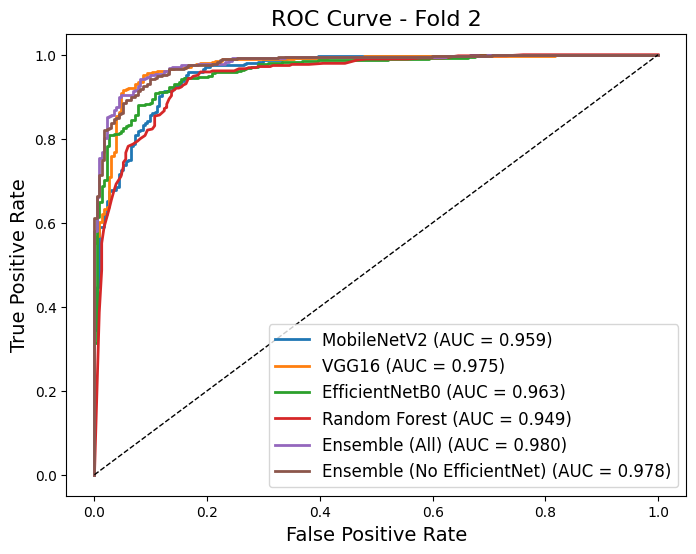


Fold 4/5
Treinando MobileNetV2
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 395ms/step - accuracy: 0.9202 - auc_3: 0.9705 - loss: 0.1951 - val_accuracy: 0.9541 - val_auc_3: 0.9886 - val_loss: 0.1256
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.9157 - auc_3: 0.9636 - loss: 0.2134 - val_accuracy: 0.9502 - val_auc_3: 0.9904 - val_loss: 0.1133
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 391ms/step - accuracy: 0.9220 - auc_3: 0.9695 - loss: 0.1992 - val_accuracy: 0.9407 - val_auc_3: 0.9875 - val_loss: 0.1277
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 391ms/step - accuracy: 0.9194 - auc_3: 0.9680 - loss: 0.2028 - val_accuracy: 0.9416 - val_auc_3: 0.9849 - val_loss: 0.1374
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 103s 392ms/step - accuracy: 0.9158 - auc_3: 0.9701 - loss: 0.1976 - val_accuracy: 0.9589 - val_auc_3: 0.9884 - val_loss: 0.1231
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.9236 - auc_3: 0.9690 - loss: 0.1987 - val_accuracy: 0.9388

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


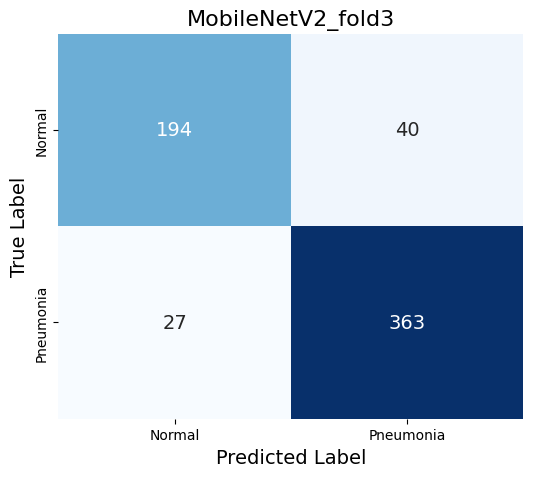

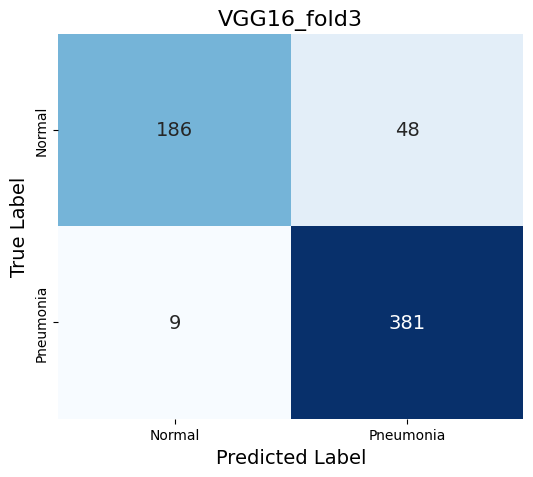

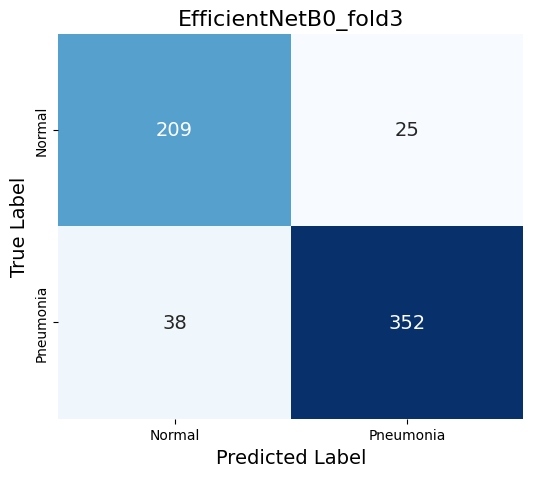

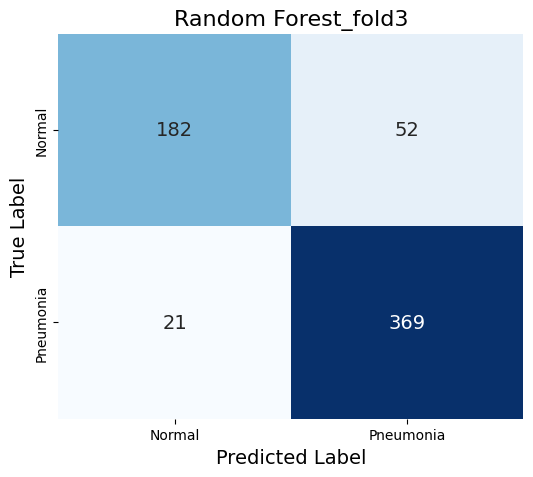

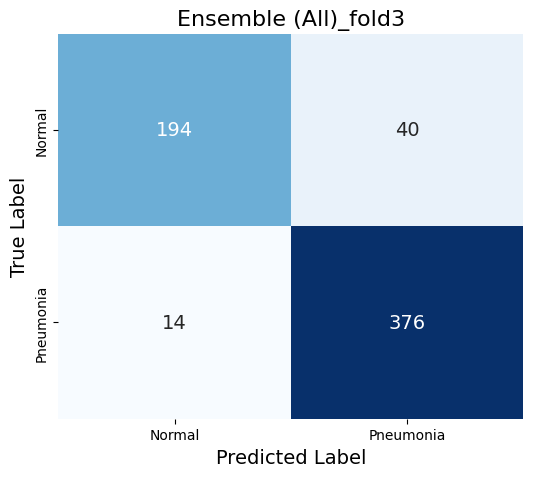

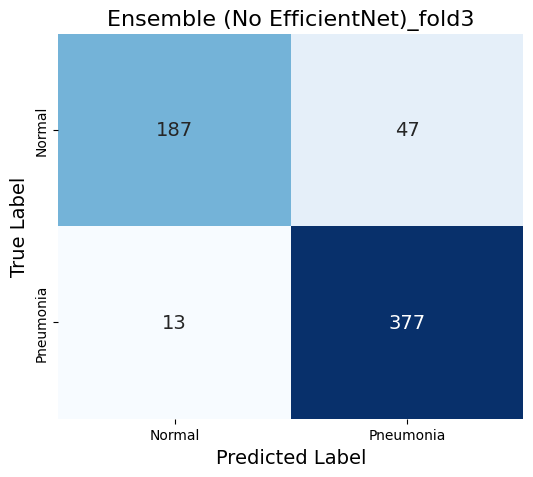

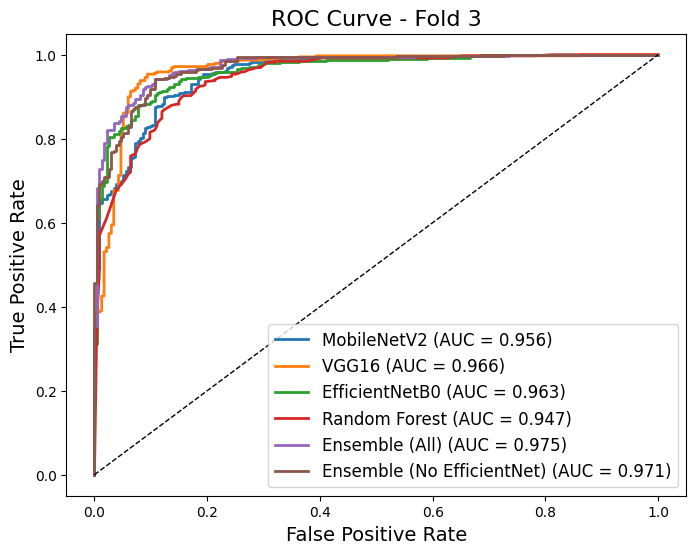


Fold 5/5
Treinando MobileNetV2
Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 391ms/step - accuracy: 0.9323 - auc_3: 0.9771 - loss: 0.1711 - val_accuracy: 0.9483 - val_auc_3: 0.9901 - val_loss: 0.1263
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 391ms/step - accuracy: 0.9270 - auc_3: 0.9744 - loss: 0.1819 - val_accuracy: 0.9502 - val_auc_3: 0.9897 - val_loss: 0.1174
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.9203 - auc_3: 0.9719 - loss: 0.1878 - val_accuracy: 0.9589 - val_auc_3: 0.9918 - val_loss: 0.1065
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 389ms/step - accuracy: 0.9311 - auc_3: 0.9737 - loss: 0.1836 - val_accuracy: 0.9455 - val_auc_3: 0.9877 - val_loss: 0.1272
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 390ms/step - accuracy: 0.9302 - auc_3: 0.9774 - loss: 0.1739 - val_accuracy: 0.9598 - val_auc_3: 0.9927 - val_loss: 0.0982
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 102s 390ms/step - accuracy: 0.9342 - auc_3: 0.9803 - loss: 0.1553 - val_accuracy: 0.9522

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_866']
Received: inputs=Tensor(shape=(16, 224, 224, 3))
  warnings.warn(msg)


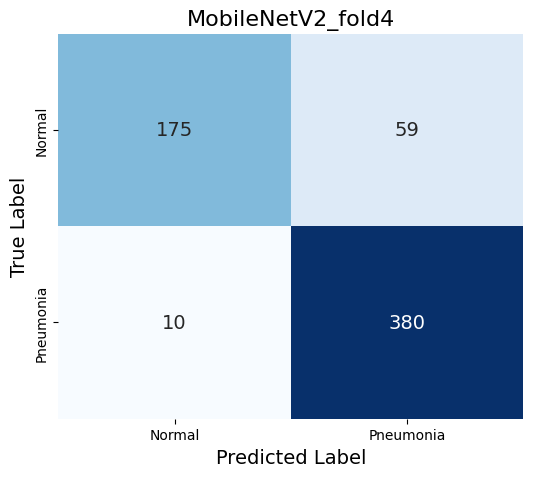

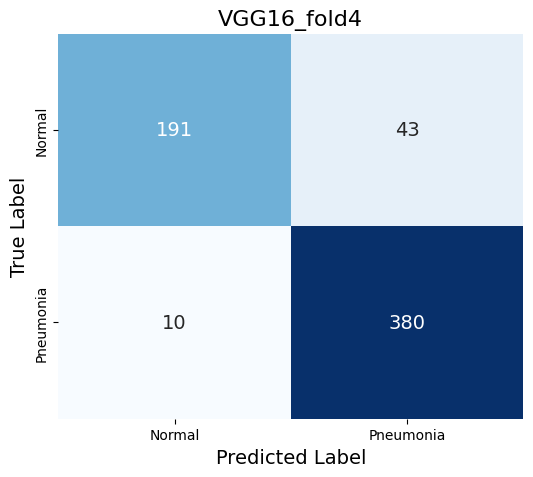

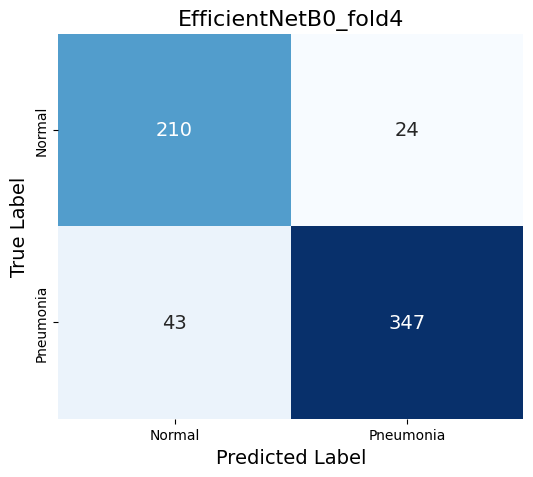

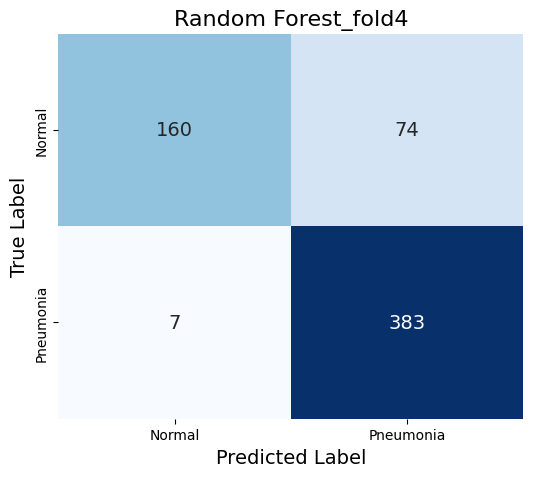

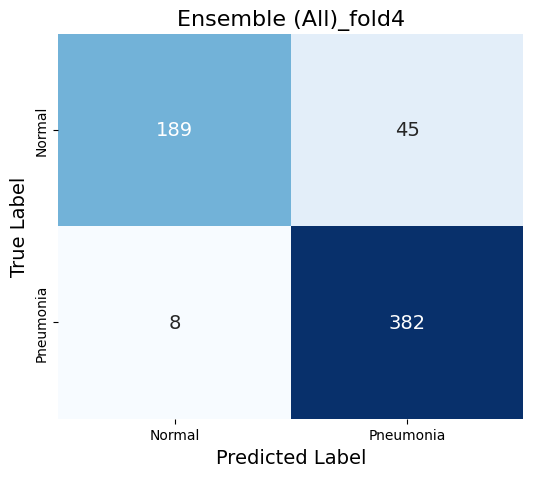

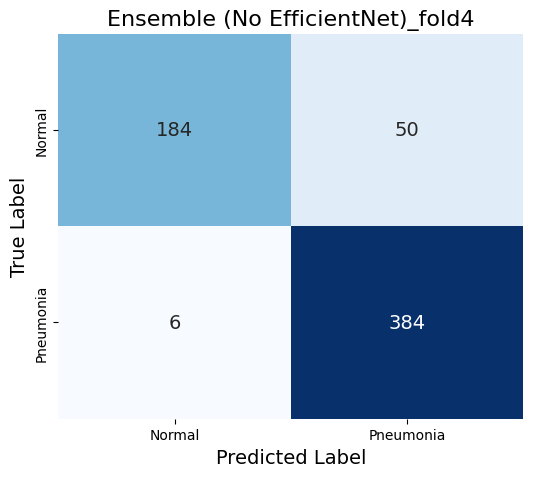

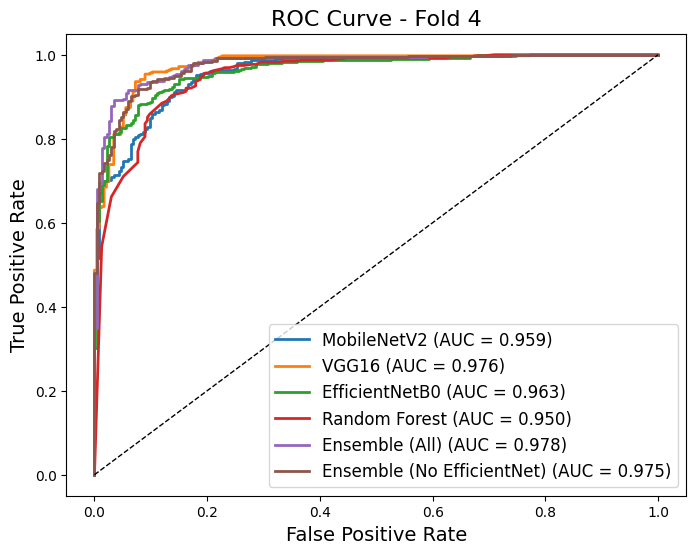

In [ ]:
results, y_preds, histories = classifier.train_models(train_generator, val_generator, test_generator)

In [ ]:
with open(f"{RESULTS_DIR}/y_preds.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open(f"{RESULTS_DIR}/histories.pkl", "wb") as f:
    pickle.dump(histories, f)

In [ ]:
gc.collect()

121446

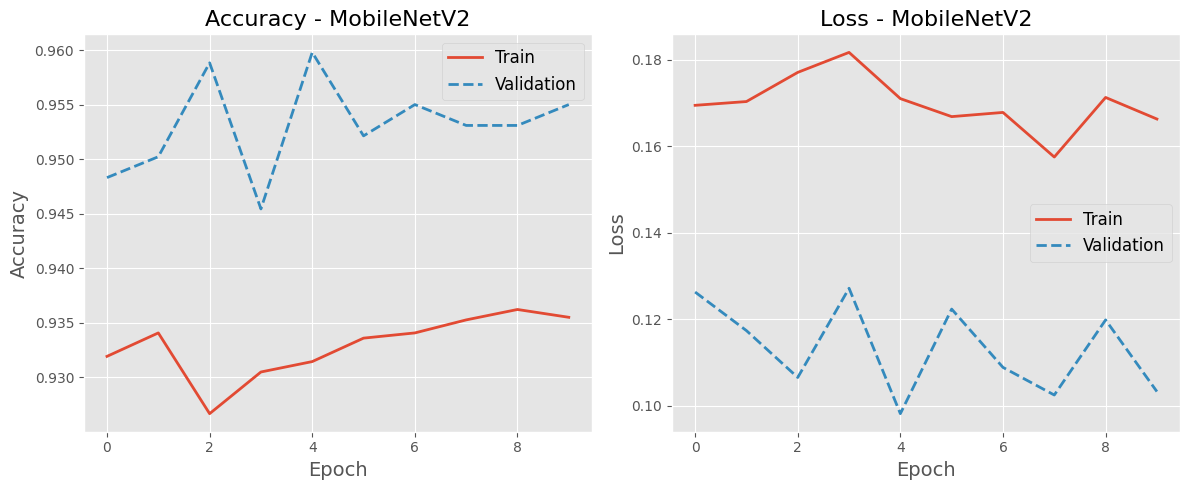

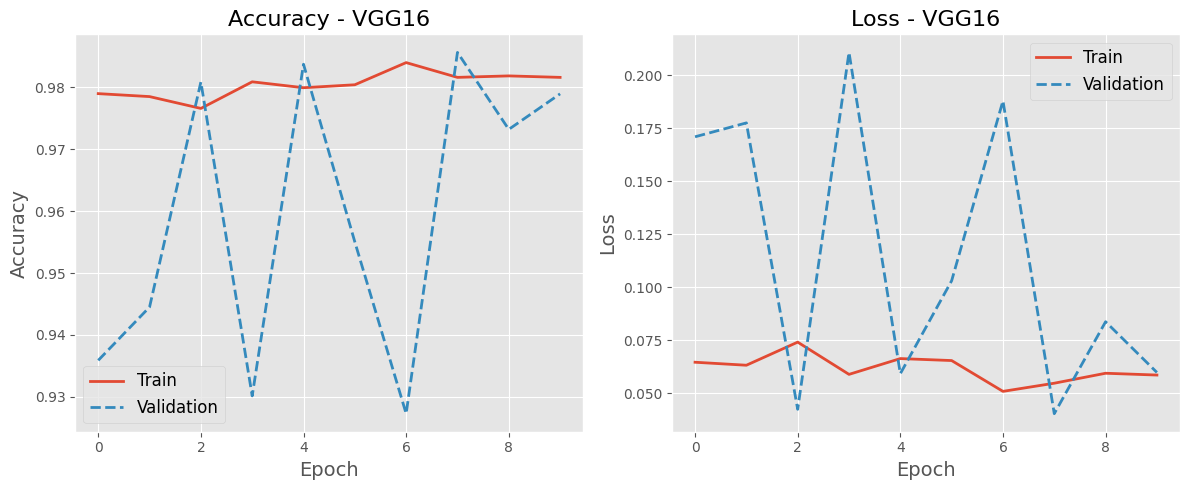

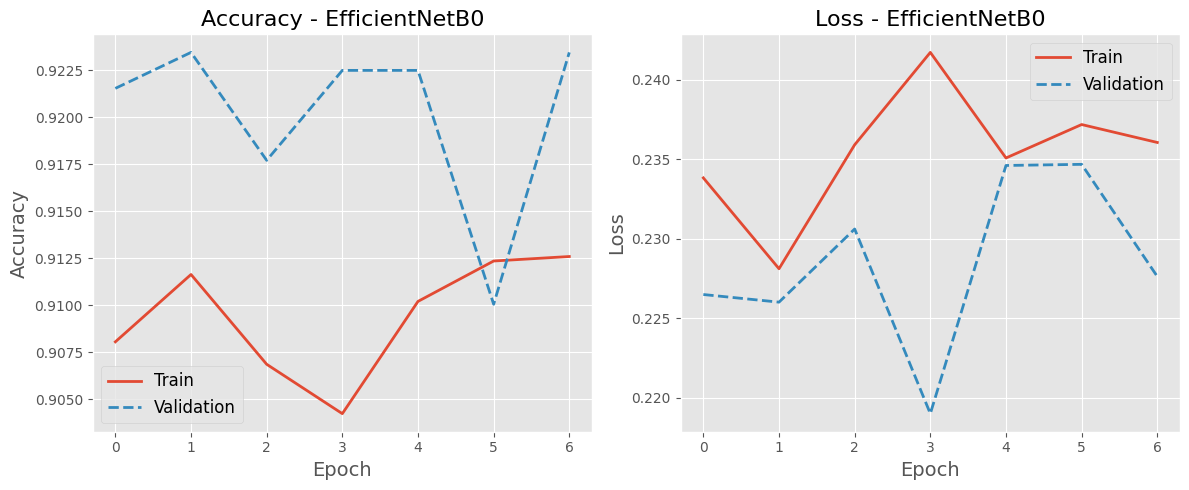

In [ ]:
classifier.plot_training_history()

In [ ]:
gc.collect()

59379

### SVM classifier

In [ ]:
svm_classifier = SVMKFoldEvaluator(classifier.models, RESULTS_DIR)

In [ ]:
X_train, y_train = svm_classifier.extract_features(train_generator)
svm_classifier.run_grid_search(X_train, y_train)

In [ ]:
svm_metrics_folds, y_probs_svm, y_true_svm = svm_classifier.evaluate(train_generator)

In [ ]:
avg_svm_metrics = {
    key: float(np.mean([fold[key] for fold in svm_metrics_folds]))
    for key in svm_metrics_folds[0].keys()
}

Ensemble SVM

In [ ]:
results["SVM (Ensemble Features)"] = [avg_svm_metrics]
y_preds["SVM (Ensemble Features)"] = y_probs_svm

In [ ]:
ensemble_rf_svm_preds = (y_preds["Random Forest"] + np.array(y_probs_svm)) / 2
y_preds["Ensemble (RF+SVM)"] = ensemble_rf_svm_preds

In [ ]:
ensemble_rf_svm_metrics = classifier.save_metrics(
    test_generator.classes,
    ensemble_rf_svm_preds,
    "Ensemble (RF+SVM)"
)
results["Ensemble (RF+SVM)"] = [ensemble_rf_svm_metrics]

In [ ]:
with open(os.path.join(RESULTS_DIR, "results.json"), "w") as f:
    json.dump(results, f, indent=4)
with open(os.path.join(RESULTS_DIR, "y_preds.pkl"), "wb") as f:
    pickle.dump(y_preds, f)

## Results

In [ ]:
results

{'MobileNetV2': [{'accuracy': 0.8573717948717948,
   'balanced_accuracy': np.float64(0.8183760683760684),
   'precision': 0.8697019211725094,
   'recall': 0.8573717948717948,
   'f1-score': 0.8508351266859728,
   'f1-macro': 0.8360565725267232,
   'auc': np.float64(0.9434363357440281)},
  {'accuracy': 0.9006410256410257,
   'balanced_accuracy': np.float64(0.8846153846153846),
   'precision': 0.9009090492764243,
   'recall': 0.9006410256410257,
   'f1-score': 0.8995532469275244,
   'f1-macro': 0.8918399069590598,
   'auc': np.float64(0.9545912776682008)},
  {'accuracy': 0.907051282051282,
   'balanced_accuracy': np.float64(0.8923076923076922),
   'precision': 0.9072543879644405,
   'recall': 0.907051282051282,
   'f1-score': 0.9061383928571428,
   'f1-macro': 0.8990178571428571,
   'auc': np.float64(0.9592044707429324)},
  {'accuracy': 0.8926282051282052,
   'balanced_accuracy': np.float64(0.8799145299145299),
   'precision': 0.8921507809078966,
   'recall': 0.8926282051282052,
   'f1-s

In [ ]:
# classifier.plot_confusion_matrix(test_generator.classes, y_probs_svm, "SVM (Ensemble Features)")
import numpy as np

classifier.plot_confusion_matrix(
    test_generator.classes,
    np.array(y_preds["SVM (Ensemble Features)"]),
    "SVM (Ensemble Features)"
)

In [ ]:
classifier.plot_confusion_matrix(
    test_generator.classes,
    np.array(y_preds["Ensemble (RF+SVM)"]),
    "Ensemble (RF+SVM)"
)

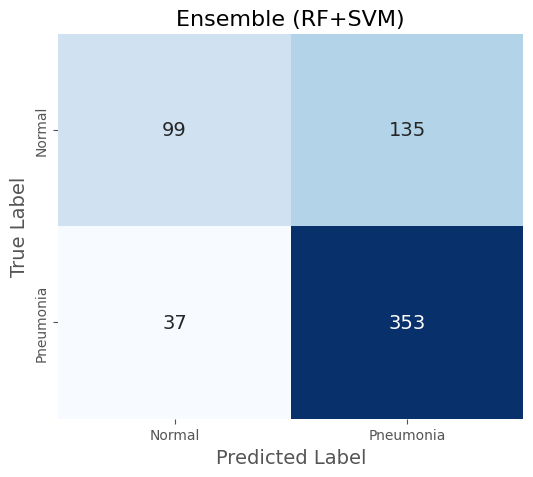

In [ ]:
classifier.plot_confusion_matrix(test_generator.classes, ensemble_rf_svm_preds, "Ensemble (RF+SVM)")

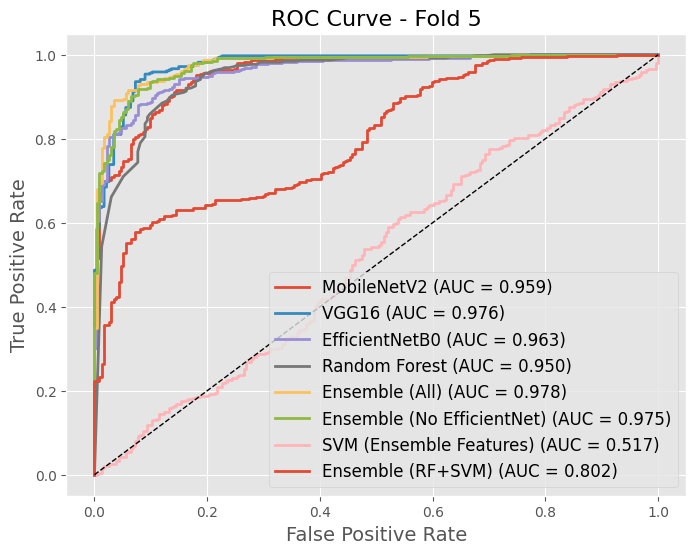

In [ ]:
if "SVM (GridSearch)" in y_preds:
    del y_preds["SVM (GridSearch)"]

classifier.plot_roc_curves(test_generator.classes, y_preds, fold=classifier.k_folds)

In [ ]:
with open(os.path.join(RESULTS_DIR, "results.json"), "w") as f:
    json.dump(results, f, indent=4)

with open(os.path.join(RESULTS_DIR, "y_preds.pkl"), "wb") as f:
    pickle.dump(y_preds, f)

In [ ]:
print("\nFinal results (average between folds):")
for model_name, fold_results in results.items():
    if model_name == "SVM (Ensemble Features)":
        print(f"\n{model_name}:")
        for metric, value in fold_results[0].items():
            print(f"{metric}: {value:.4f}")
    else:
        avg_metrics = {
            metric: np.mean([fold[metric] for fold in fold_results if metric in fold])
            for metric in ["accuracy", "balanced_accuracy", "precision", "recall", "f1-score", "f1-macro", "auc"]
            if any(metric in fold for fold in fold_results)
        }
        print(f"\n{model_name}:")
        for metric, value in avg_metrics.items():
            print(f"{metric}: {value:.4f}")


Resultados finais (média entre folds):

MobileNetV2:
accuracy: 0.8894
balanced_accuracy: 0.8673
precision: 0.8931
recall: 0.8894
f1-score: 0.8869
f1-macro: 0.8774
auc: 0.9545

VGG16:
accuracy: 0.9183
balanced_accuracy: 0.9026
precision: 0.9206
recall: 0.9183
f1-score: 0.9172
f1-macro: 0.9107
auc: 0.9694

EfficientNetB0:
accuracy: 0.8955
balanced_accuracy: 0.8959
precision: 0.8983
recall: 0.8955
f1-score: 0.8962
f1-macro: 0.8901
auc: 0.9632

Random Forest:
accuracy: 0.8782
balanced_accuracy: 0.8525
precision: 0.8820
recall: 0.8782
f1-score: 0.8752
f1-macro: 0.8645
auc: 0.9450

Ensemble (All):
accuracy: 0.9192
balanced_accuracy: 0.9021
precision: 0.9212
recall: 0.9192
f1-score: 0.9180
f1-macro: 0.9115
auc: 0.9773

Ensemble (No EfficientNet):
accuracy: 0.9109
balanced_accuracy: 0.8899
precision: 0.9148
recall: 0.9109
f1-score: 0.9091
f1-macro: 0.9015
auc: 0.9739

SVM (Ensemble Features):
accuracy: 0.9343
balanced_accuracy: 0.9331
f1_macro: 0.9300
f1_weighted: 0.9345
auc: 0.9790

Ensemble

### Confusion_matrix

In [ ]:
def plot_aggregated_confusion_matrix(results_dir, model_name, num_folds=5):

    total_cm = None

    for fold in range(num_folds):
        cm_path = os.path.join(results_dir, f"{model_name}_fold{fold}_confusion_matrix.npy")
        if not os.path.exists(cm_path):
            print(f"[WARNING] Matrix not found: {cm_path}")
            continue

        cm = np.load(cm_path)
        if total_cm is None:
            total_cm = cm
        else:
            total_cm += cm

    if total_cm is None:
        print(f"[ERROR] No array found for {model_name}")
        return

    plt.figure(figsize=(6, 5))
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14},
                xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predict', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title(f'Aggregate Confusion Matrix - {model_name}', fontsize=16)
    plt.tight_layout()
    save_path = os.path.join(results_dir, f"{model_name}_confusion_matrix_SUM.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

In [ ]:
def plot_all_model_losses(histories, results_dir):
    plt.figure(figsize=(10, 6))
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f'{model_name} - Train')
        plt.plot(history['val_loss'], label=f'{model_name} - Val', linestyle='--')

    plt.title("Loss Curves - All Models")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "all_models_loss.png"), dpi=300)
    plt.show()


In [ ]:
def plot_comparative_metrics_table(results, results_dir):
    metrics_to_plot = ["accuracy", "f1-score", "f1-macro", "auc"]
    data = []

    for model_name, metrics_list in results.items():
        if not metrics_list: continue
        avg_metrics = {
            metric: np.mean([fold[metric] for fold in metrics_list if metric in fold])
            for metric in metrics_to_plot
        }
        avg_metrics['model'] = model_name
        data.append(avg_metrics)

    df = pd.DataFrame(data).set_index("model")
    df.plot(kind='bar', figsize=(12, 6))
    plt.title("Comparison of Metrics by Model")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "comparative_metrics.png"), dpi=300)
    plt.show()
    df.to_csv(os.path.join(results_dir, "final_results_table.csv"))
    return df

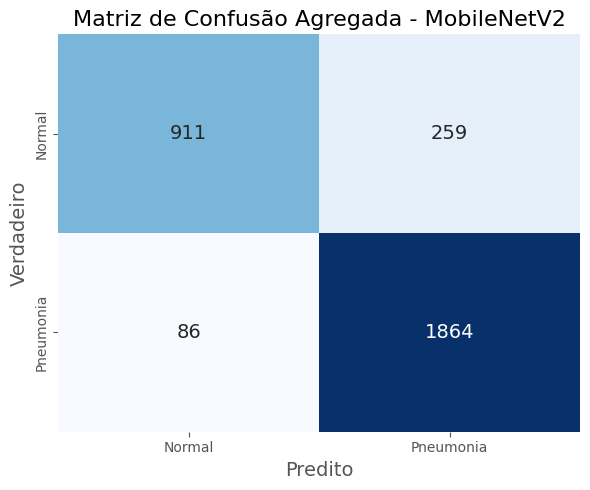

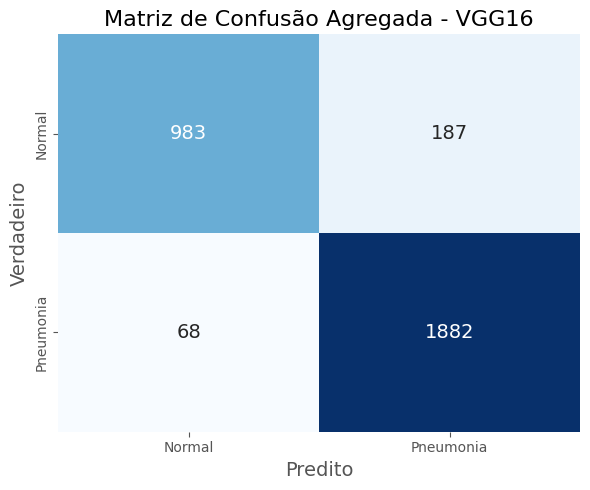

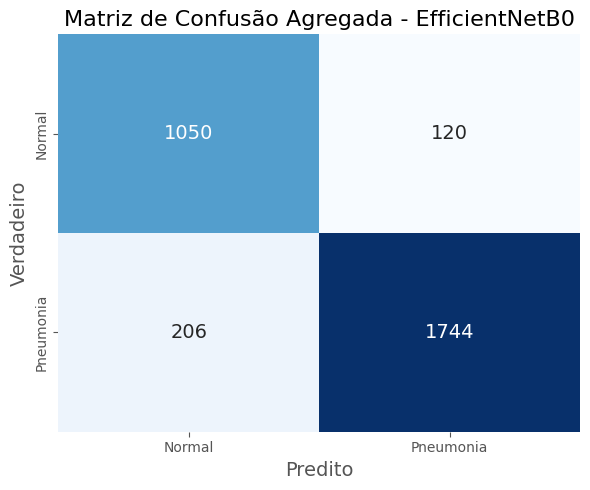

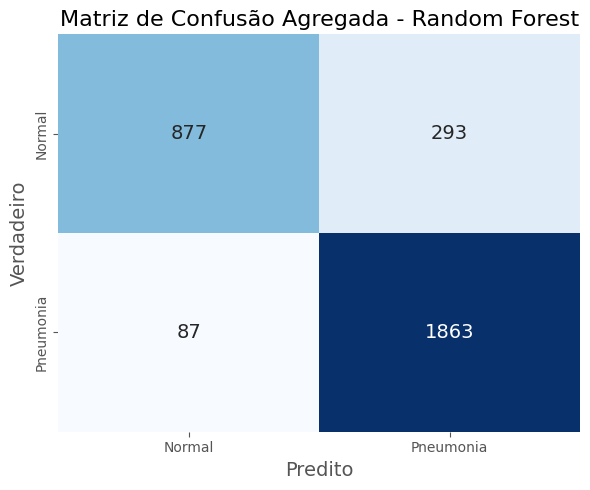

In [ ]:
for model_name in results.keys():
    if "fold" not in model_name and "SVM" not in model_name and "Ensemble" not in model_name:
        plot_aggregated_confusion_matrix(RESULTS_DIR, model_name, num_folds=5)

In [ ]:
for model_name in results:
    if "SVM" in model_name:
        plot_aggregated_confusion_matrix(RESULTS_DIR, "svm_confusion_matrix", num_folds=5)

classifier.plot_confusion_matrix(
    test_generator.classes,
    y_preds["Ensemble (RF+SVM)"],
    "Ensemble (RF+SVM)"
)

classifier.plot_roc_curves(test_generator.classes, y_preds, fold=classifier.k_folds)

print("\nFinal results (average between folds):")
for model_name, fold_results in results.items():
    print(f"\n{model_name}:")
    for metric, value in fold_results[0].items():
        print(f"{metric}: {value:.4f}")


df_summary = plot_comparative_metrics_table(results, RESULTS_DIR)

In [ ]:
df_summary

In [ ]:
# classifier.plot_confusion_matrix(test_generator.classes, y_preds["SVM (Ensemble Features)"], "SVM (Ensemble Features)")
# classifier.plot_confusion_matrix(test_generator.classes, y_preds["Ensemble (RF+SVM)"], "Ensemble (RF+SVM)")

In [ ]:
def export_final_results_table(results, results_dir):
    all_data = []
    for model_name, metric_list in results.items():
        if not metric_list: continue
        metrics_avg = {
            'Model': model_name,
            **{k: np.mean([m[k] for m in metric_list if k in m]) for k in metric_list[0].keys()}
        }
        all_data.append(metrics_avg)

    df = pd.DataFrame(all_data).set_index("Model")
    df.to_csv(os.path.join(results_dir, "final_metrics_summary.csv"))
    print("Exported metrics table")
    return df

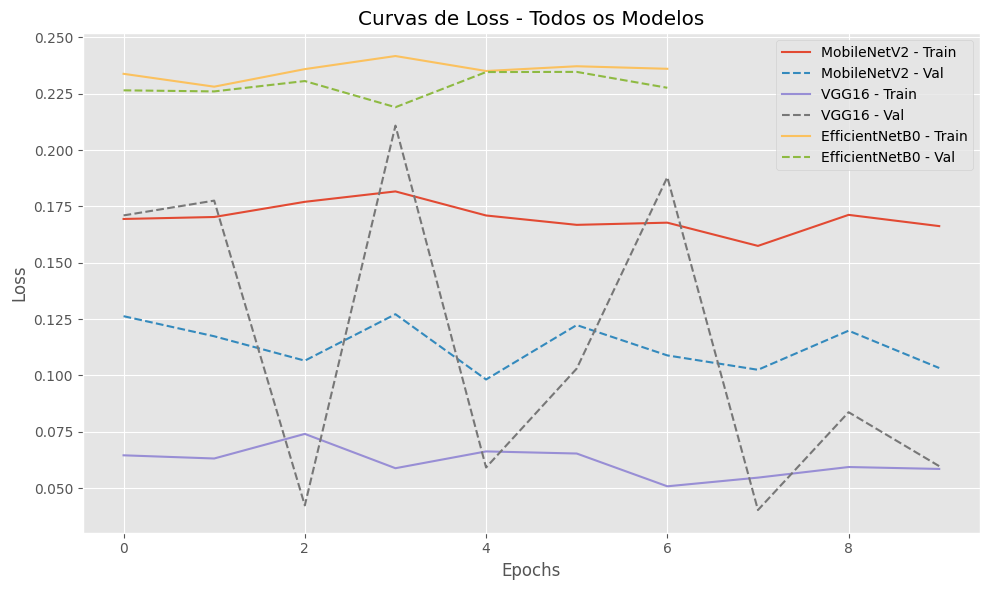

In [ ]:
plot_all_model_losses(histories, RESULTS_DIR)

In [ ]:
export_final_results_table(results, RESULTS_DIR)

Tabela de métricas exportada.


,accuracy,balanced_accuracy,precision,recall,f1-score,f1-macro,auc,f1_macro,f1_weighted
Model,,,,,,,,,
MobileNetV2,0.889423,0.867265,0.893150,0.889423,0.886945,0.877418,0.954482,NaN,NaN
VGG16,0.918269,0.902650,0.920575,0.918269,0.917160,0.910674,0.969373,NaN,NaN
EfficientNetB0,0.895513,0.895897,0.898281,0.895513,0.896187,0.890076,0.963154,NaN,NaN
Random Forest,0.878205,0.852479,0.882027,0.878205,0.875221,0.864454,0.945016,NaN,NaN
Ensemble (All),0.919231,0.902051,0.921223,0.919231,0.918033,0.911500,0.977261,NaN,NaN
Ensemble (No EfficientNet),0.910897,0.889915,0.914807,0.910897,0.909078,0.901480,0.973879,NaN,NaN
SVM (Ensemble Features),0.934297,0.933060,NaN,NaN,NaN,NaN,0.978969,0.930022,0.934463
Ensemble (RF+SVM),0.724359,0.664103,0.725078,0.724359,0.703238,0.669618,0.801523,NaN,NaN


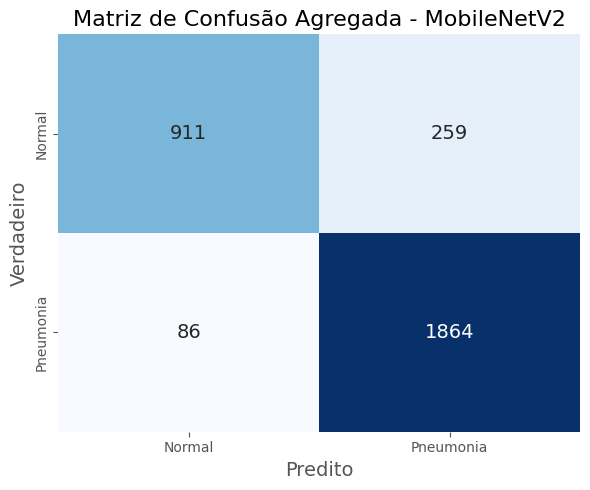

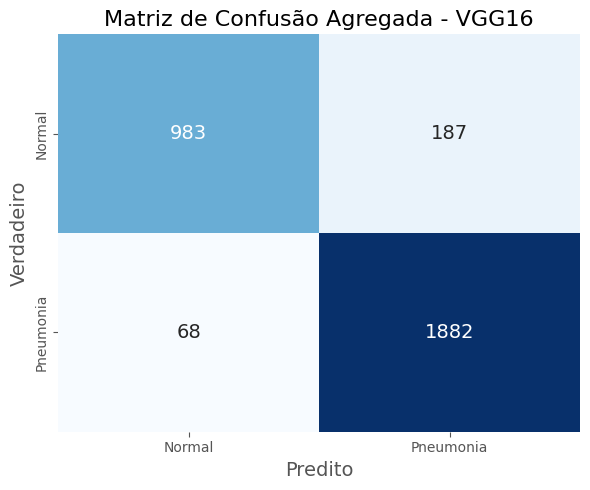

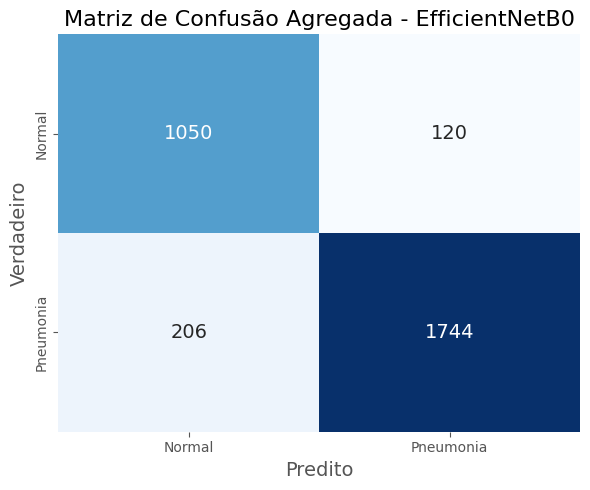

In [ ]:
for model_name in ["MobileNetV2", "VGG16", "EfficientNetB0"]:
    plot_aggregated_confusion_matrix(RESULTS_DIR, model_name, num_folds=5)

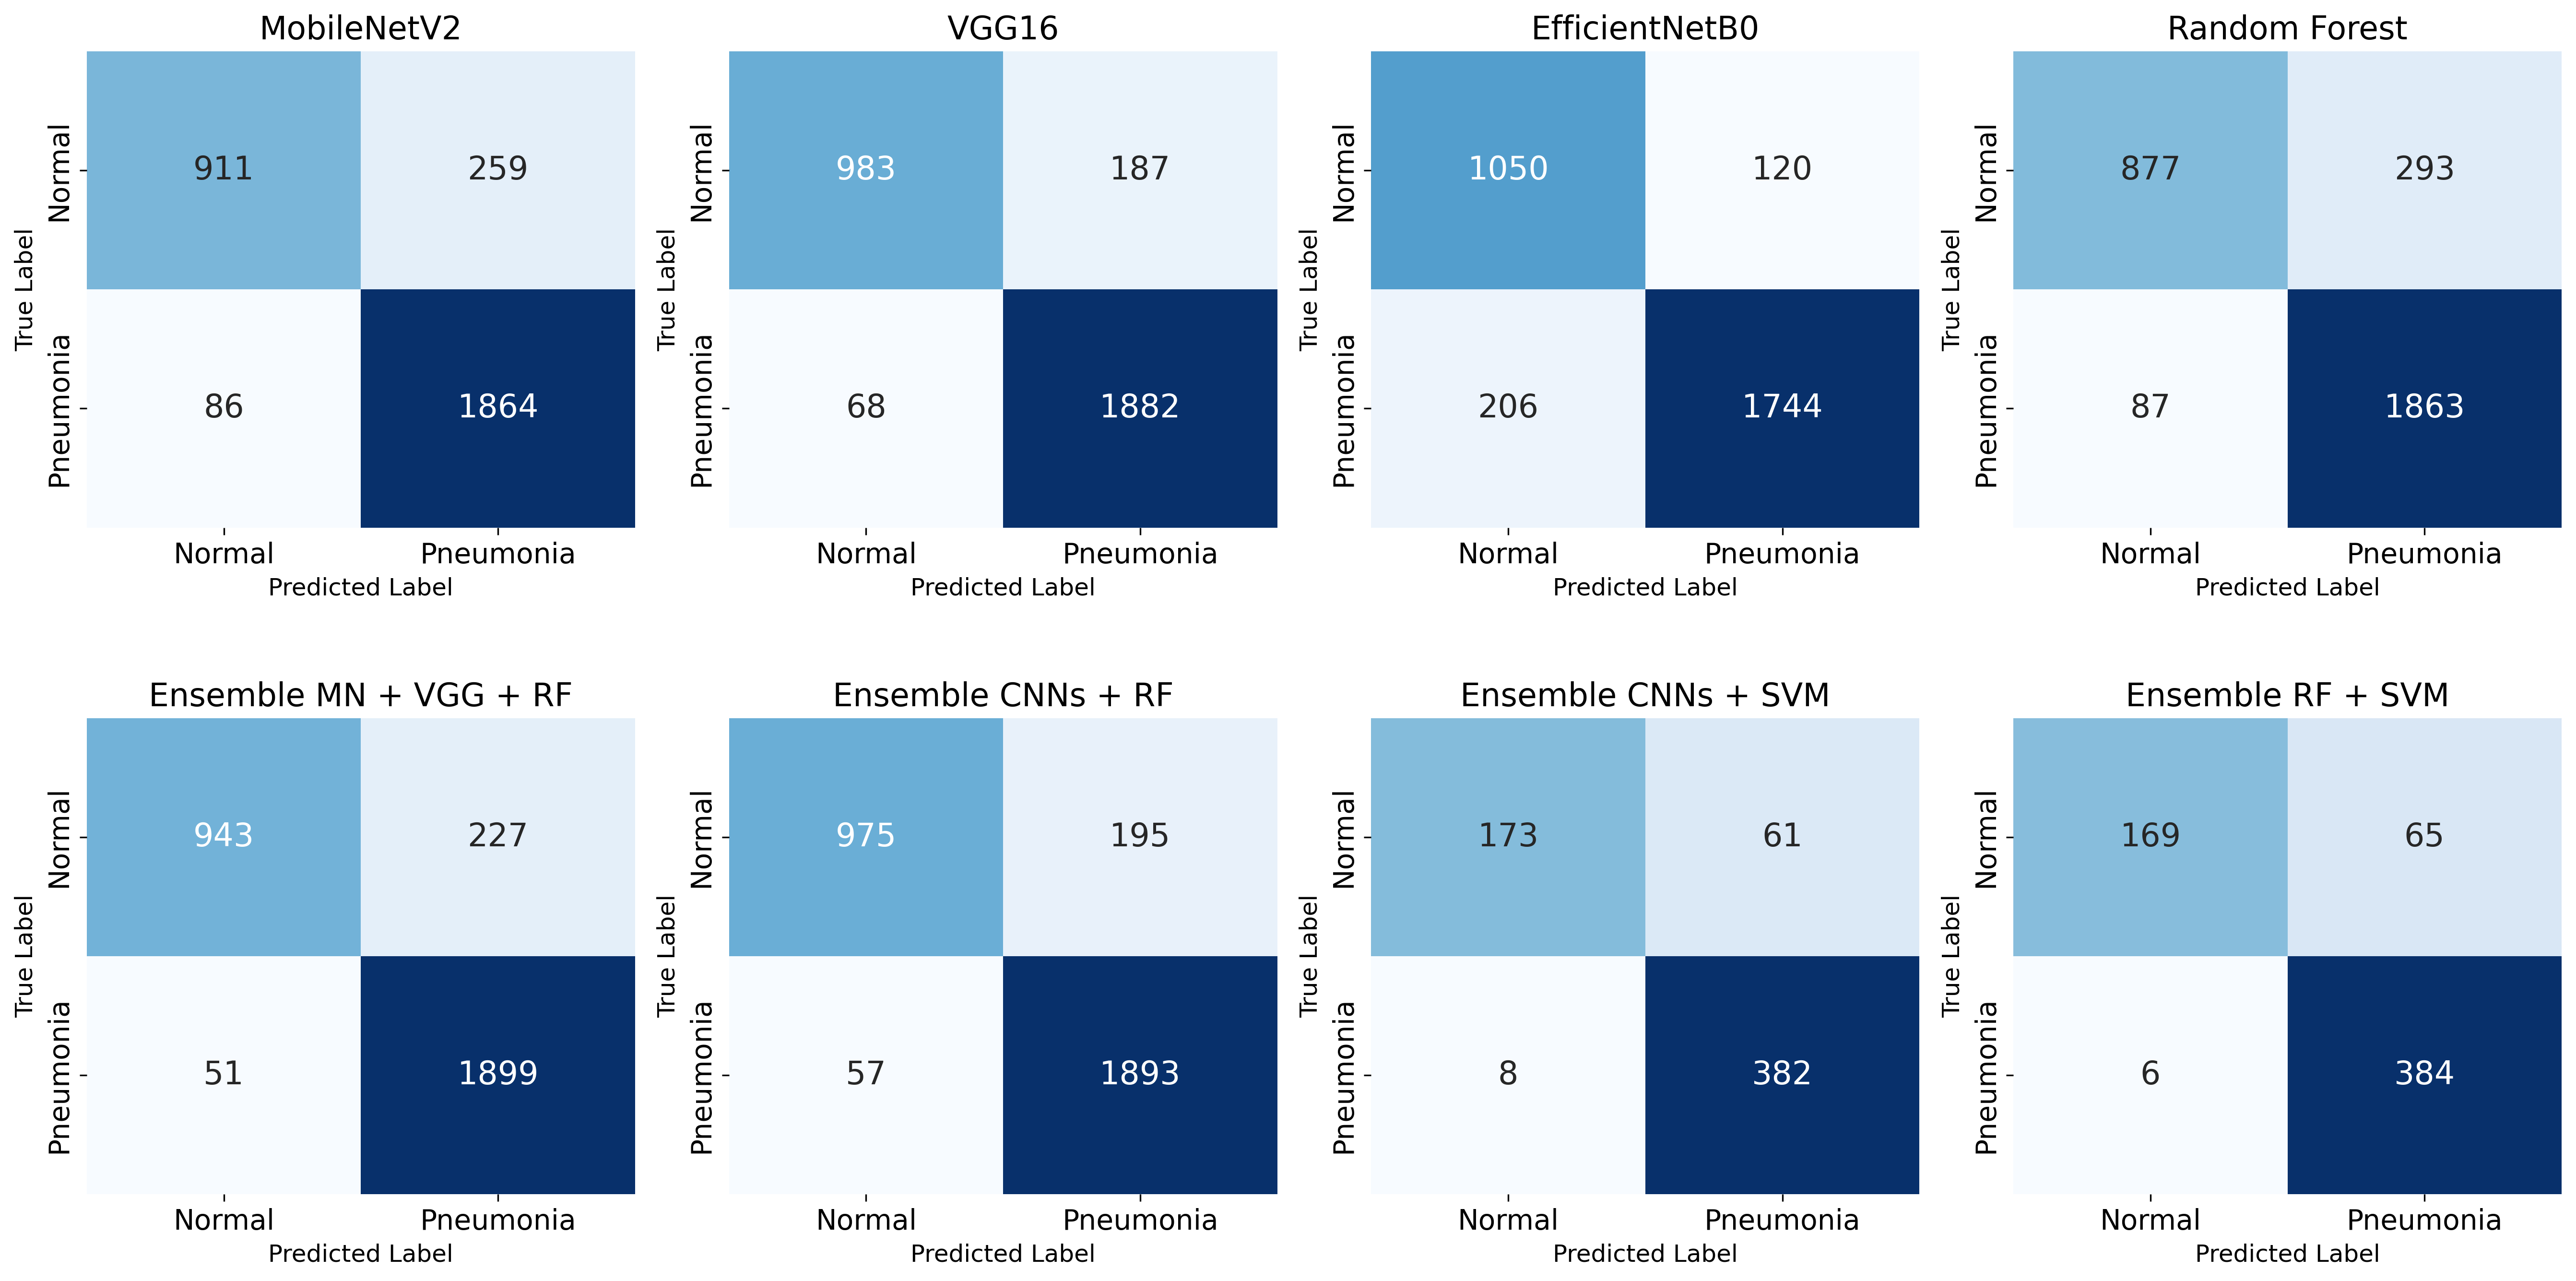

In [ ]:
conf_matrices = {
    "MobileNetV2": np.array([[911, 259], [86, 1864]]),
    "VGG16": np.array([[983, 187], [68, 1882]]),
    "EfficientNetB0": np.array([[1050, 120], [206, 1744]]),
    "Random Forest": np.array([[877, 293], [87, 1863]]),
    "Ensemble MN + VGG + RF": np.array([[943, 227], [51, 1899]]),
    "Ensemble CNNs + RF": np.array([[975, 195], [57, 1893]]),
    "Ensemble CNNs + SVM": np.array([[173, 61], [8, 382]]),
    "Ensemble RF + SVM": np.array([[169, 65], [6, 384]])
}

fig, axes = plt.subplots(2, 4, figsize=(18, 9), dpi=300)

axes = axes.flatten()

for ax, (title, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'],
                annot_kws={"size": 16}, ax=ax)
    ax.set_title(f'{title}', fontsize=16)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
# output_path = "/final_confusion_matrices.png"
# plt.savefig(output_path, dpi=300)
plt.show()


In [ ]:
def analyze_rf_feature_importance_outside_class(
    rf_model, models, test_generator, results_dir, feature_extractor_fn, feature_extractor_layers=None):
    import os
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import accuracy_score, roc_auc_score

    if rf_model is None:
        print("Error: Random Forest not trained")
        return None

    print("Extracting features for importance analysis")
    features = []
    for model_name, model in models.items():
        model_features, _ = feature_extractor_fn(model, test_generator)
        features.append(model_features)

    combined_features = np.concatenate(features, axis=1)
    y_true = test_generator.classes

    result = permutation_importance(
        rf_model, combined_features, y_true,
        n_repeats=10, random_state=42, n_jobs=-1
    )


    feature_names = []
    for model_name, model_features in zip(models.keys(), features):
        for i in range(model_features.shape[1]):
            feature_names.append(f"{model_name}_{i}")

    indices = np.argsort(result.importances_mean)[::-1]
    plt.figure(figsize=(12, 8))
    plt.title("Importance of Features - Random Forest", fontsize=16)
    plt.bar(range(30), result.importances_mean[indices[:30]])
    plt.xticks(range(30), [feature_names[idx] for idx in indices[:30]], rotation=90, fontsize=10)
    plt.ylabel("Importance", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "rf_feature_importance.png"), dpi=300)
    plt.show()

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': result.importances_mean,
        'StdDev': result.importances_std
    }).sort_values('Importance', ascending=False)
    importance_df.to_csv(os.path.join(results_dir, "rf_feature_importance.csv"), index=False)

    if feature_extractor_layers:
        layer_results = {}

        for model_name, layers in feature_extractor_layers.items():
            model = models[model_name]
            for layer_idx in layers:
                layer_name = model.layers[layer_idx].name
                layer_extractor = tf.keras.Model(
                    inputs=model.input,
                    outputs=model.layers[layer_idx].output
                )

                features = []
                test_generator.reset()
                for _ in range(len(test_generator)):
                    batch_x, _ = next(test_generator)
                    batch_features = layer_extractor.predict(batch_x, verbose=0)
                    batch_features = np.reshape(batch_features, (batch_features.shape[0], -1))
                    features.append(batch_features)

                layer_features = np.concatenate(features)

                layer_rf = RandomForestClassifier(n_estimators=100, random_state=42)
                layer_rf.fit(layer_features, y_true)
                y_pred = layer_rf.predict(layer_features)
                y_proba = layer_rf.predict_proba(layer_features)[:, 1]

                layer_results[f"{model_name}_{layer_name}"] = {
                    'accuracy': accuracy_score(y_true, y_pred),
                    'auc': roc_auc_score(y_true, y_proba)
                }

                print(f"{model_name}_{layer_name}: acc={layer_results[f'{model_name}_{layer_name}']['accuracy']:.4f}, auc={layer_results[f'{model_name}_{layer_name}']['auc']:.4f}")

        with open(os.path.join(results_dir, "layer_performance.json"), "w") as f:
            json.dump(layer_results, f, indent=4)

    return importance_df


In [ ]:
rf_importance_df = analyze_rf_feature_importance_outside_class(
    rf_model=classifier.rf_model,
    models=classifier.models,
    test_generator=classifier.datagens["standard"]["test"],
    results_dir=RESULTS_DIR,
    feature_extractor_fn=classifier.extract_features,
    feature_extractor_layers={
        'MobileNetV2': [-3, -5, -7],
        'VGG16': [-3, -5, -7],
        'EfficientNetB0': [-3, -5, -7]
    }
)

## Statistical test

In [ ]:
!pip install scikit-posthocs -qqq

In [ ]:
import json
import os
import pandas as pd
import scikit_posthocs as sp
from scipy import stats

RESULTS_DIR = "/content/drive/MyDrive/UEMA/DEEP LEARNING/Atividade IV/saved_results_15_05"

In [ ]:
with open(os.path.join(RESULTS_DIR, "results.json"), "r") as f:
    results = json.load(f)

In [ ]:
# # carregar resultados do SVM K-Fold
# svm_path = os.path.join(RESULTS_DIR, "svm_kfold_metrics.json")
# with open(svm_path, "r") as f:
#     svm_folds = json.load(f)
# results["SVM (Ensemble Features)"] = svm_folds

In [ ]:
metricas_alvo = ["accuracy", "balanced_accuracy", "precision", "recall", "f1-score", "f1-macro", "auc"]

In [ ]:
dados_por_modelo = {
    modelo: [fold for fold in folds if isinstance(fold, dict)]
    for modelo, folds in results.items()
    if len(folds) > 1  # para testes estatísticos
}

In [ ]:
print("Kruskal-Wallis test ")
for metrica in metricas_alvo:
    dados_metricas = []
    nomes_modelos = []

    for modelo, folds in dados_por_modelo.items():
        valores = [fold[metrica] for fold in folds if metrica in fold]
        if len(valores) > 1:
            dados_metricas.append(valores)
            nomes_modelos.append(modelo)

    if len(dados_metricas) < 2:
        continue

    h_stat, p_value = stats.kruskal(*dados_metricas)
    print(f"\n{metrica.upper()}:")
    print(f"  H = {h_stat:.4f}, p = {p_value:.4f}")
    if p_value < 0.05:
        print(" Statistically significant difference")
    else:
        print(" No significant difference")

print("\nDunn test (post-hoc) para Accuracy")

fold_data = []
for modelo, folds in dados_por_modelo.items():
    for i, fold in enumerate(folds):
        if "accuracy" in fold:
            fold_data.append({
                "Model": modelo,
                "Fold": i,
                "Accuracy": fold["accuracy"]
            })

df_long = pd.DataFrame(fold_data)

In [ ]:
dunn_results = sp.posthoc_dunn(
    df_long,
    val_col="Accuracy",
    group_col="Model",
    p_adjust="bonferroni"
)

print("\nP-value matrix (Dunn - Accuracy):")
print(dunn_results)

dunn_csv_path = os.path.join(RESULTS_DIR, "dunn_test_accuracy_with_svm.csv")
dunn_results.to_csv(dunn_csv_path)
print(f"\nDunn: {dunn_csv_path}")

### Teste de Kruskal-Wallis ###

ACCURACY:
  H = 22.3256, p = 0.0005
  → Diferença estatisticamente significativa

BALANCED_ACCURACY:
  H = 18.2603, p = 0.0026
  → Diferença estatisticamente significativa

PRECISION:
  H = 23.0593, p = 0.0003
  → Diferença estatisticamente significativa

RECALL:
  H = 22.3256, p = 0.0005
  → Diferença estatisticamente significativa

F1-SCORE:
  H = 22.1094, p = 0.0005
  → Diferença estatisticamente significativa

F1-MACRO:
  H = 20.7827, p = 0.0009
  → Diferença estatisticamente significativa

AUC:
  H = 25.6245, p = 0.0001
  → Diferença estatisticamente significativa

### Teste de Dunn (post-hoc) para Accuracy ###

Matriz de p-valores (Dunn - Accuracy):
                            EfficientNetB0  Ensemble (All)  \
EfficientNetB0                    1.000000        0.186514   
Ensemble (All)                    0.186514        1.000000   
Ensemble (No EfficientNet)        1.000000        1.000000   
MobileNetV2                       1.000000        0.123

In [ ]:
history_path = os.path.join(RESULTS_DIR, "histories.pkl")

with open(history_path, "rb") as f:
    histories = pickle.load(f)
print("Modelos disponíveis:", list(histories.keys()))

Modelos disponíveis: ['MobileNetV2', 'VGG16', 'EfficientNetB0']


In [ ]:
histories

{'MobileNetV2': {'accuracy': [0.9319321513175964,
   0.9340816736221313,
   0.9266778230667114,
   0.9304991364479065,
   0.9314544796943665,
   0.9336040019989014,
   0.9340816736221313,
   0.9352758526802063,
   0.9362311959266663,
   0.9355146884918213],
  'auc_3': [0.9771803617477417,
   0.97735196352005,
   0.9746303558349609,
   0.9734728336334229,
   0.9773823618888855,
   0.9776193499565125,
   0.977203905582428,
   0.9800646305084229,
   0.9764278531074524,
   0.9783506989479065],
  'loss': [0.16941778361797333,
   0.17029111087322235,
   0.1770256906747818,
   0.18164503574371338,
   0.1709665209054947,
   0.166808620095253,
   0.16777773201465607,
   0.1574723869562149,
   0.171237513422966,
   0.16625267267227173],
  'val_accuracy': [0.9483253359794617,
   0.9502392411231995,
   0.95885169506073,
   0.9454545378684998,
   0.9598085880279541,
   0.9521530866622925,
   0.9550239443778992,
   0.9531100392341614,
   0.9531100392341614,
   0.9550239443778992],
  'val_auc_3': [0.